## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2024                               # What year to start the run on? (default: 2024)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/minimal_menace')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/minimal_menace.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-12-26 12:04:37.600517


{1: 24.0,
 5: 25.1,
 10: 25.9,
 20: 26.8,
 30: 27.8,
 40: 29.3,
 50: 31.2,
 60: 33.1,
 70: 35.2,
 80: 37.5,
 90: 40.8,
 95: 43.8,
 99: 50.10100000000002}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2023-12-26 13:42:13.814001


{1: 8.5,
 5: 8.7,
 10: 8.8,
 20: 9.0,
 30: 9.1,
 40: 9.2,
 50: 9.3,
 60: 9.4,
 70: 9.6,
 80: 9.7,
 90: 9.9,
 95: 10.1,
 99: 10.4}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-12-26 12:09:10.919020


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.05:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.6:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 20),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=1325745391 has the best chip at 18.59 log FLOP. But INT16 / INT8 should allow a 5x-10x improvement. 
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 54113.77it/s]


{1: 0.00034,
 5: 0.0008,
 10: 0.00103,
 20: 0.00116,
 30: 0.00125,
 40: 0.00134,
 50: 0.00145,
 60: 0.00164,
 70: 0.00277,
 80: 0.00761,
 90: 0.01192,
 95: 0.01451,
 99: 0.02048}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.034%',
 5: '0.08%',
 10: '0.103%',
 20: '0.116%',
 30: '0.125%',
 40: '0.134%',
 50: '0.145%',
 60: '0.164%',
 70: '0.277%',
 80: '0.761%',
 90: '1.192%',
 95: '1.451%',
 99: '2.048%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '8 billion',
 5: '20 billion',
 10: '26 billion',
 20: '29 billion',
 30: '31 billion',
 40: '34 billion',
 50: '36 billion',
 60: '41 billion',
 70: '69 billion',
 80: '191 billion',
 90: '300 billion',
 95: '365 billion',
 99: '517 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1047737.81it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00028,
 40: 0.00037,
 50: 0.00049,
 60: 0.00066,
 70: 0.00096,
 80: 0.0017,
 90: 0.00366,
 95: 0.0059,
 99: 0.01151}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.028%',
 40: '0.037%',
 50: '0.049%',
 60: '0.066%',
 70: '0.096%',
 80: '0.17%',
 90: '0.366%',
 95: '0.59%',
 99: '1.151%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '7 billion',
 40: '9 billion',
 50: '12 billion',
 60: '17 billion',
 70: '24 billion',
 80: '43 billion',
 90: '92 billion',
 95: '148 billion',
 99: '288 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~196 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 3.4 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 26.0 log FLOP - log 2023$USD 7.3 to buy TAI vs. willingness to pay log $ 9.1 - 18.7 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> No

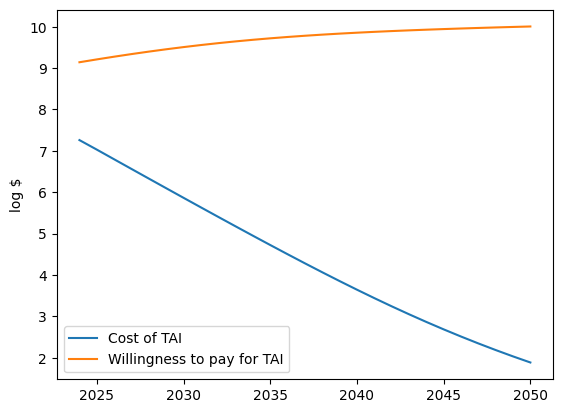

-
-
## SAMPLE RUN 2 ##
It takes 31.0 log FLOP (~10 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~33 quintillion) per 2023$USD. Every 3.1 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~322 sextillion) per 2023$USD.
We are initially willing to pay 9.5 log 2023$USD (~3 billion). This doubles every 0.9 year to a max of 0.045274% of GDP (initially ~11 billion 2023$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2024 - 28.9 max log FLOP available - TAI takes 31.0 log FLOP - log 2023$USD 11.5 to buy TAI vs. willingness to pay log $ 9.4 - 19.5 log FLOP per $ (Total FLOP 28.9 vs. Effective 2023-logFLOP: 28.9)
Year: 2025 - 29.2 max log FLOP available - TAI takes 30.9 log FLOP - log 2023$USD 11.3 to buy TAI vs. willingness to pay log $ 9.6 - 19.6 log FLOP per $ (Total FLOP 29.2 vs. Effective 2023-logFLOP: 29.3)
Year: 2026 - 29.5 max log FLOP available - TAI takes 30.

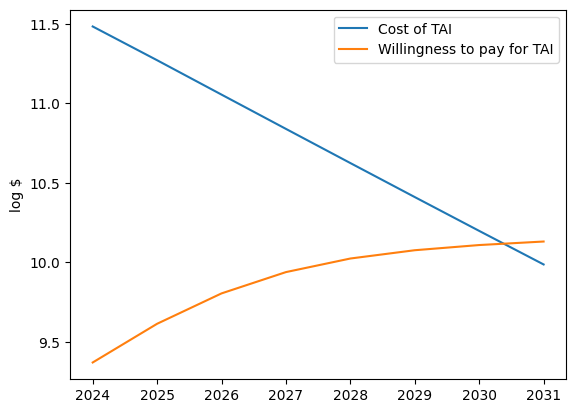

-
-
## SAMPLE RUN 3 ##
It takes 43.4 log FLOP (~25 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~981 million). This doubles every 2.2 year to a max of 0.210158% of GDP (initially ~53 billion 2023$USD). GDP grows at a rate of 1.036x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 43.4 log FLOP - log 2023$USD 24.5 to buy TAI vs. willingness to pay log $ 9.0 - 18.9 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.2 max log FLOP available - TAI takes 43.1 log FLOP - log 2023$USD 24.1 to buy TAI vs. willingness to pay log $ 9.1 - 19.0 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.5)
Year: 2026 - 28.4 max log FLOP available - TAI take

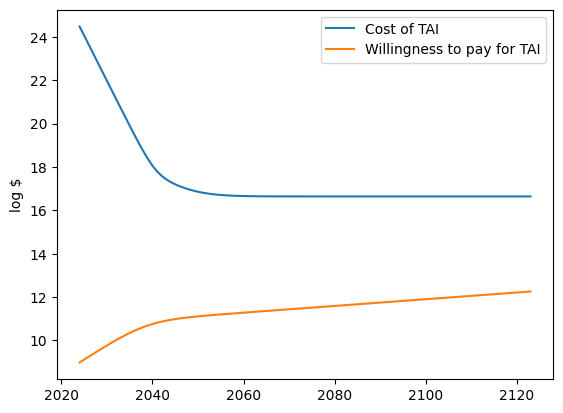

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.52it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 677.59it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2036',
 '35%: 2039',
 '50%: 2044',
 '60%: 2049',
 '75%: 2067',
 '80%: 2090',
 '90%: >2124',
 '95%: >2124']
(Mean: 2059)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 6 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 12 years from now',
 '35%: 15 years from now',
 '50%: 20 years from now',
 '60%: 25 years from now',
 '75%: 43 years from now',
 '80%: 66 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 35 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.3%
2024-2025: 0.3%
2026-2027: 1.1%
2028-2029: 3.5%
2030-2034: 16.5%
2035-2039: 17.7%
2040-2049: 22.8%
2050-2059: 9.8%
2060-2069: 5.0%
2070-2079: 2.7%
2080-2089: 1.2%
2090-2099: 0.7%


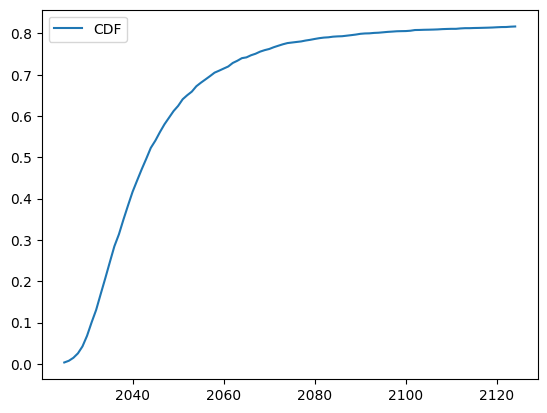

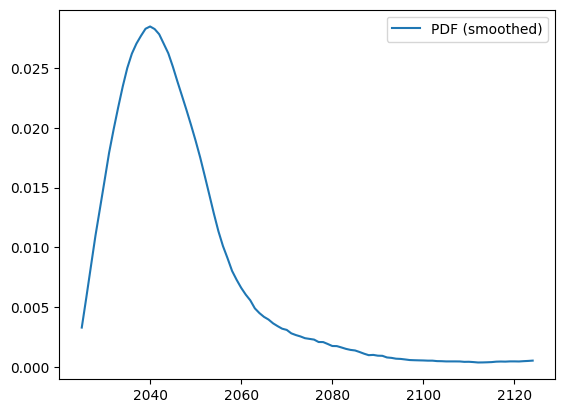

-
-
## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.1,
 10: 25.8,
 20: 26.8,
 30: 28.0,
 40: 29.5,
 50: 31.5,
 60: 33.6,
 70: 35.4,
 80: 38.0,
 90: 41.1,
 95: 44.6,
 99: 50.2}
(Mean: 32.7)


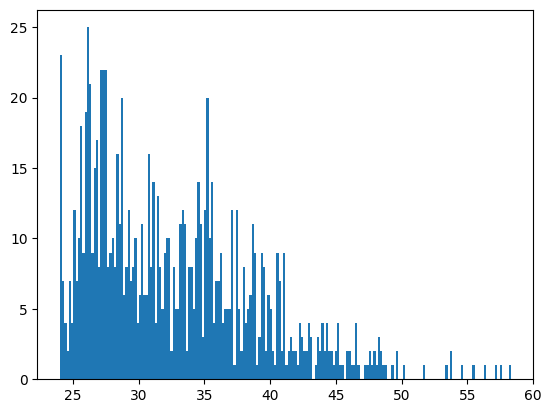

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.7,
 5: 14.4,
 10: 12.3,
 20: 9.9,
 30: 8.7,
 40: 7.6,
 50: 6.8,
 60: 6.1,
 70: 5.2,
 80: 4.4,
 90: 3.7,
 95: 3.0,
 99: 2.2}
(Mean: 7.5)


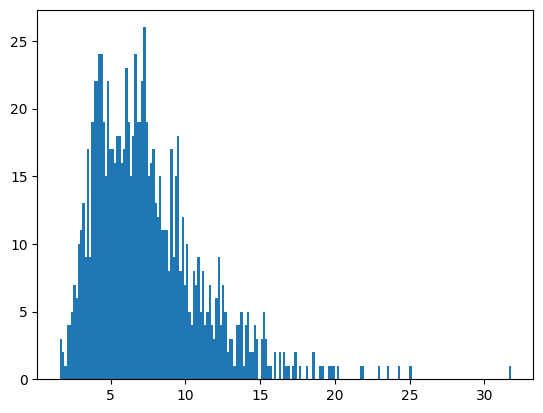

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.7,
 5: 18.1,
 10: 18.2,
 20: 18.5,
 30: 18.7,
 40: 18.9,
 50: 19.0,
 60: 19.2,
 70: 19.3,
 80: 19.5,
 90: 19.8,
 95: 20.0,
 99: 20.4}
(Mean: 19.0)


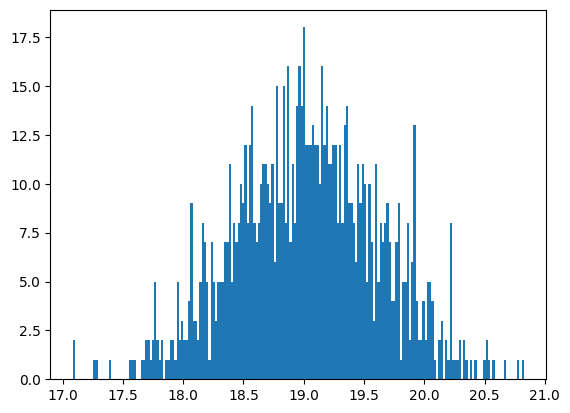

-
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.7,
 30: 2.6,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}
(Mean: 2.5)


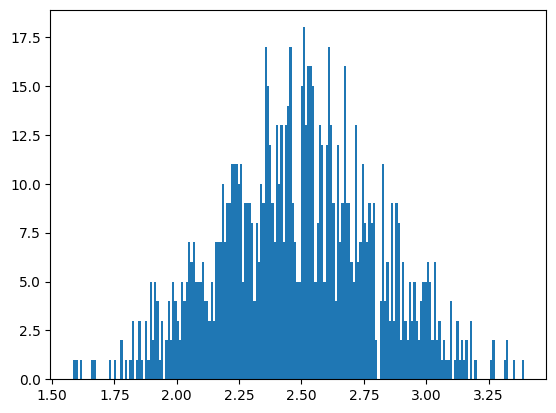

-
-
## MAX FLOP PER DOLLAR ##
{1: 19.8,
 5: 21.1,
 10: 21.6,
 20: 22.1,
 30: 22.7,
 40: 23.1,
 50: 23.5,
 60: 23.9,
 70: 24.3,
 80: 24.8,
 90: 25.4,
 95: 26.0,
 99: 26.8}
(Mean: 23.5)


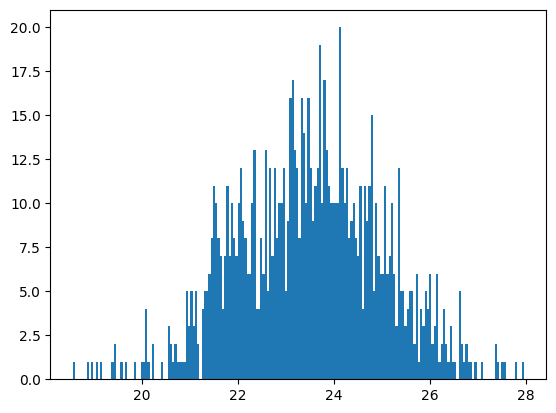

-
-
## INITIAL PAY ##
{1: 8.5,
 5: 8.7,
 10: 8.8,
 20: 9.0,
 30: 9.1,
 40: 9.2,
 50: 9.3,
 60: 9.4,
 70: 9.6,
 80: 9.7,
 90: 9.9,
 95: 10.1,
 99: 10.4}
(Mean: 9.3)


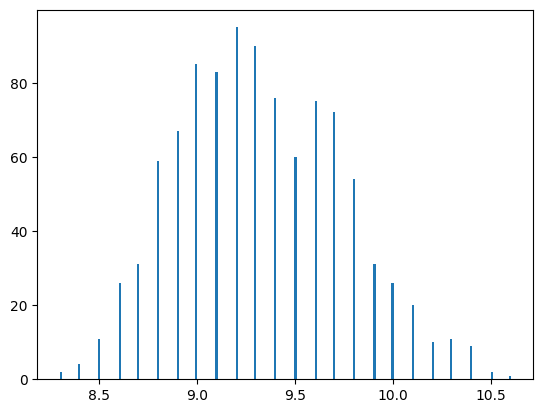

-
-
## INITIAL GDP ##
{1: 24837900252212.8,
 5: 24909677650762.36,
 10: 24964732012023.06,
 20: 25012175850600.06,
 30: 25053357639676.26,
 40: 25087804287639.54,
 50: 25124236144285.3,
 60: 25153164743486.72,
 70: 25189060000804.6,
 80: 25229199919741.64,
 90: 25284769110780.67,
 95: 25326047762888.77,
 99: 25404311100462.64}
(Mean: 25121742674228.7)


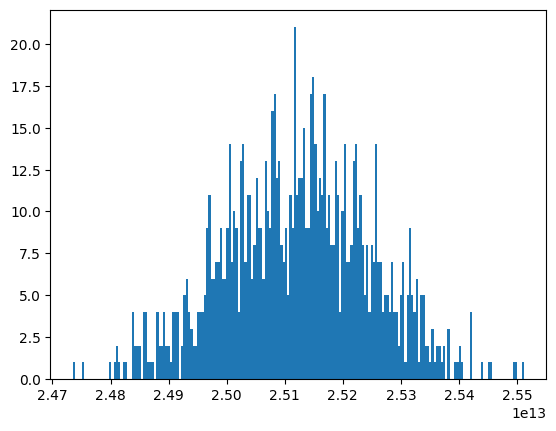

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


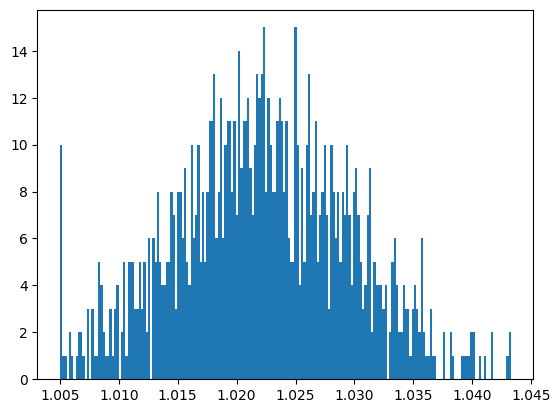

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00029,
 40: 0.00037,
 50: 0.0005,
 60: 0.00064,
 70: 0.00094,
 80: 0.00154,
 90: 0.00297,
 95: 0.00518,
 99: 0.00995}
(Mean: 0.0)


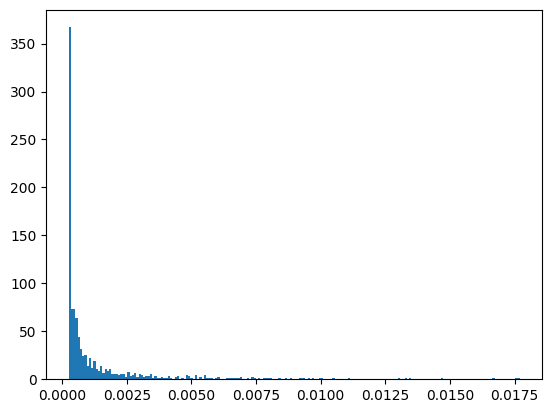

-
-
## SPEND DOUBLING TIME ##
{1: 11.8,
 5: 8.6,
 10: 6.6,
 20: 4.9,
 30: 4.1,
 40: 3.4,
 50: 2.9,
 60: 2.5,
 70: 2.1,
 80: 1.7,
 90: 1.2,
 95: 1.0,
 99: 0.9}
(Mean: 3.6)


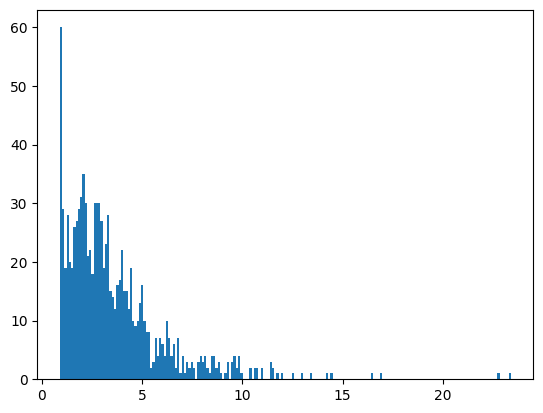

-
-
-
-
## GDP Over Time ##


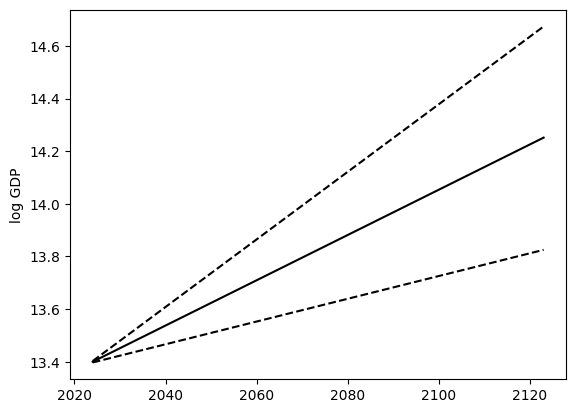

Year: 2024 - GDP log 2023$USD 13.4 (~25 trillion) 90% CI 13.4 (~25 trillion) - 13.4 (~25 trillion)
Year: 2025 - GDP log 2023$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.4 (~26 trillion)
Year: 2026 - GDP log 2023$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.4 (~27 trillion)
Year: 2027 - GDP log 2023$USD 13.4 (~27 trillion) 90% CI 13.4 (~26 trillion) - 13.4 (~28 trillion)
Year: 2028 - GDP log 2023$USD 13.4 (~27 trillion) 90% CI 13.4 (~26 trillion) - 13.5 (~28 trillion)
Year: 2029 - GDP log 2023$USD 13.4 (~28 trillion) 90% CI 13.4 (~26 trillion) - 13.5 (~29 trillion)
Year: 2030 - GDP log 2023$USD 13.5 (~28 trillion) 90% CI 13.4 (~27 trillion) - 13.5 (~30 trillion)
Year: 2031 - GDP log 2023$USD 13.5 (~29 trillion) 90% CI 13.4 (~27 trillion) - 13.5 (~31 trillion)
Year: 2032 - GDP log 2023$USD 13.5 (~29 trillion) 90% CI 13.4 (~27 trillion) - 13.5 (~32 trillion)
Year: 2033 - GDP log 2023$USD 13.5 (~30 trillion) 90% CI 13.4 (~27 trillion) - 13.5 (~33 trillion)
Year: 2034

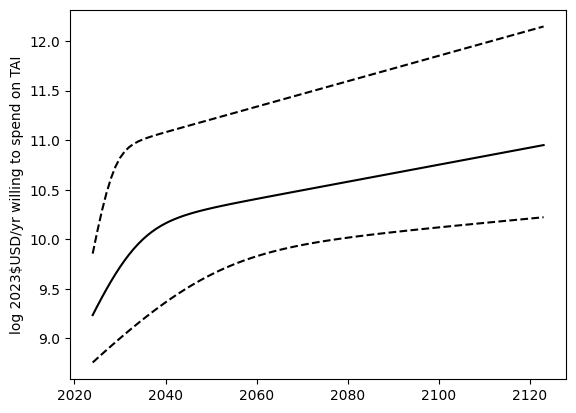

Year: 2024 - willingness log 2023$USD per year 9.2 (~2 billion) 90% CI 8.8 (~573 million) - 9.9 (~7 billion)
Year: 2025 - willingness log 2023$USD per year 9.3 (~2 billion) 90% CI 8.8 (~631 million) - 10.1 (~12 billion)
Year: 2026 - willingness log 2023$USD per year 9.4 (~3 billion) 90% CI 8.8 (~694 million) - 10.3 (~19 billion)
Year: 2027 - willingness log 2023$USD per year 9.5 (~3 billion) 90% CI 8.9 (~762 million) - 10.5 (~29 billion)
Year: 2028 - willingness log 2023$USD per year 9.6 (~4 billion) 90% CI 8.9 (~837 million) - 10.6 (~41 billion)
Year: 2029 - willingness log 2023$USD per year 9.7 (~4 billion) 90% CI 9.0 (~918 million) - 10.7 (~54 billion)
Year: 2030 - willingness log 2023$USD per year 9.7 (~5 billion) 90% CI 9.0 (~1 billion) - 10.8 (~66 billion)
Year: 2031 - willingness log 2023$USD per year 9.8 (~6 billion) 90% CI 9.0 (~1 billion) - 10.9 (~77 billion)
Year: 2032 - willingness log 2023$USD per year 9.8 (~7 billion) 90% CI 9.1 (~1 billion) - 10.9 (~85 billion)
Year: 203

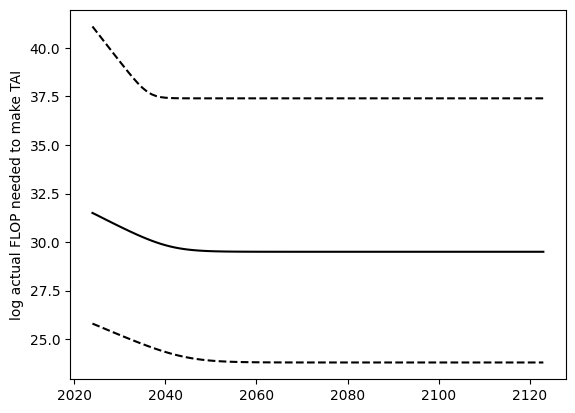

Year: 2024 - log FLOP needed for TAI 31.5 (~32 nonillion) 90% CI 25.8 (~63 septillion) - 41.1 (~126 million decillion)
Year: 2025 - log FLOP needed for TAI 31.4 (~24 nonillion) 90% CI 25.7 (~51 septillion) - 40.8 (~63 million decillion)
Year: 2026 - log FLOP needed for TAI 31.3 (~18 nonillion) 90% CI 25.6 (~40 septillion) - 40.5 (~31 million decillion)
Year: 2027 - log FLOP needed for TAI 31.1 (~14 nonillion) 90% CI 25.5 (~32 septillion) - 40.2 (~16 million decillion)
Year: 2028 - log FLOP needed for TAI 31.0 (~11 nonillion) 90% CI 25.4 (~26 septillion) - 39.9 (~8 million decillion)
Year: 2029 - log FLOP needed for TAI 30.9 (~8 nonillion) 90% CI 25.3 (~21 septillion) - 39.6 (~4 million decillion)
Year: 2030 - log FLOP needed for TAI 30.8 (~6 nonillion) 90% CI 25.2 (~16 septillion) - 39.3 (~2 million decillion)
Year: 2031 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 25.1 (~13 septillion) - 39.0 (~1 million decillion)
Year: 2032 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% C

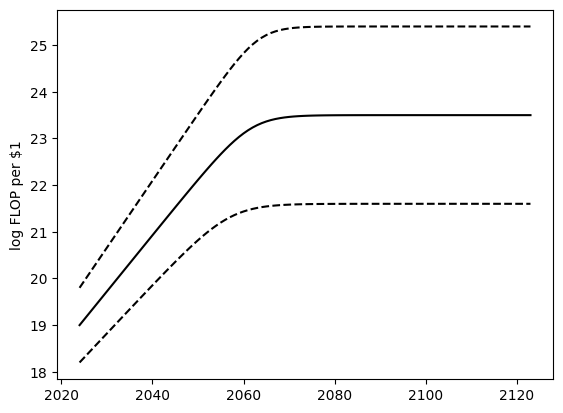

Year: 2024 - log FLOP per 2023$1USD 19.0 (~10 quintillion) 90% CI 18.2 (~2 quintillion) - 19.8 (~63 quintillion)
Year: 2025 - log FLOP per 2023$1USD 19.1 (~13 quintillion) 90% CI 18.3 (~2 quintillion) - 19.9 (~88 quintillion)
Year: 2026 - log FLOP per 2023$1USD 19.2 (~17 quintillion) 90% CI 18.4 (~3 quintillion) - 20.1 (~122 quintillion)
Year: 2027 - log FLOP per 2023$1USD 19.4 (~23 quintillion) 90% CI 18.5 (~3 quintillion) - 20.2 (~170 quintillion)
Year: 2028 - log FLOP per 2023$1USD 19.5 (~30 quintillion) 90% CI 18.6 (~4 quintillion) - 20.4 (~236 quintillion)
Year: 2029 - log FLOP per 2023$1USD 19.6 (~40 quintillion) 90% CI 18.7 (~5 quintillion) - 20.5 (~329 quintillion)
Year: 2030 - log FLOP per 2023$1USD 19.7 (~53 quintillion) 90% CI 18.8 (~7 quintillion) - 20.7 (~457 quintillion)
Year: 2031 - log FLOP per 2023$1USD 19.8 (~70 quintillion) 90% CI 18.9 (~8 quintillion) - 20.8 (~636 quintillion)
Year: 2032 - log FLOP per 2023$1USD 20.0 (~92 quintillion) 90% CI 19.0 (~11 quintillion) -

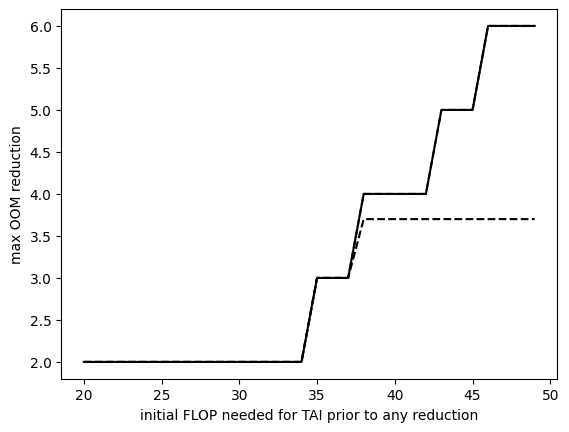

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

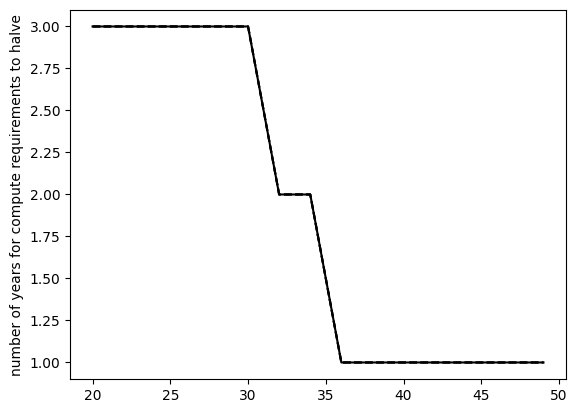

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

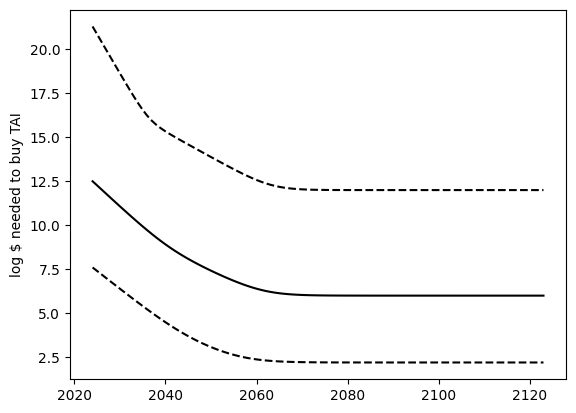

Year: 2024 - 12.5 log 2023$USD to buy TAI (~3 trillion) 90% CI 7.6 (~40 million) - 21.3 (~2 sextillion)
Year: 2025 - 12.3 log 2023$USD to buy TAI (~2 trillion) 90% CI 7.4 (~25 million) - 20.9 (~717 quintillion)
Year: 2026 - 12.0 log 2023$USD to buy TAI (~1 trillion) 90% CI 7.2 (~16 million) - 20.4 (~258 quintillion)
Year: 2027 - 11.8 log 2023$USD to buy TAI (~613 billion) 90% CI 7.0 (~10 million) - 20.0 (~93 quintillion)
Year: 2028 - 11.5 log 2023$USD to buy TAI (~355 billion) 90% CI 6.8 (~6 million) - 19.5 (~33 quintillion)
Year: 2029 - 11.3 log 2023$USD to buy TAI (~206 billion) 90% CI 6.6 (~4 million) - 19.1 (~12 quintillion)
Year: 2030 - 11.1 log 2023$USD to buy TAI (~120 billion) 90% CI 6.4 (~2 million) - 18.6 (~4 quintillion)
Year: 2031 - 10.8 log 2023$USD to buy TAI (~70 billion) 90% CI 6.2 (~2 million) - 18.2 (~2 quintillion)
Year: 2032 - 10.6 log 2023$USD to buy TAI (~41 billion) 90% CI 6.0 (~988 thousand) - 17.8 (~584 quadrillion)
Year: 2033 - 10.4 log 2023$USD to buy TAI (~2

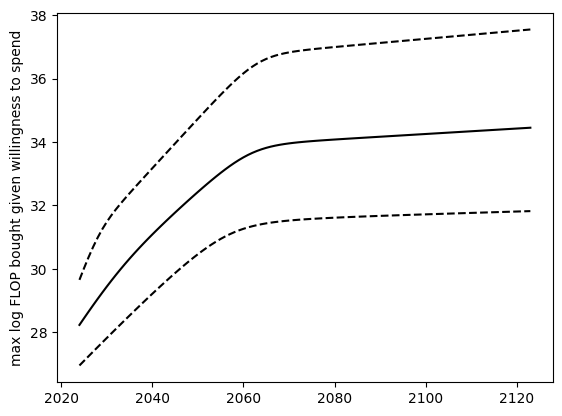

Year: 2024 - max log FLOP 28.2 (~17 octillion) 90% CI 27.0 (~908 septillion) - 29.7 (~453 octillion)
Year: 2025 - max log FLOP 28.4 (~28 octillion) 90% CI 27.1 (~1 octillion) - 30.0 (~1 nonillion)
Year: 2026 - max log FLOP 28.7 (~45 octillion) 90% CI 27.2 (~2 octillion) - 30.4 (~2 nonillion)
Year: 2027 - max log FLOP 28.9 (~72 octillion) 90% CI 27.4 (~2 octillion) - 30.7 (~5 nonillion)
Year: 2028 - max log FLOP 29.1 (~114 octillion) 90% CI 27.5 (~3 octillion) - 31.0 (~10 nonillion)
Year: 2029 - max log FLOP 29.3 (~179 octillion) 90% CI 27.7 (~5 octillion) - 31.2 (~18 nonillion)
Year: 2030 - max log FLOP 29.4 (~278 octillion) 90% CI 27.8 (~7 octillion) - 31.5 (~30 nonillion)
Year: 2031 - max log FLOP 29.6 (~426 octillion) 90% CI 28.0 (~9 octillion) - 31.7 (~49 nonillion)
Year: 2032 - max log FLOP 29.8 (~647 octillion) 90% CI 28.1 (~13 octillion) - 31.9 (~75 nonillion)
Year: 2033 - max log FLOP 30.0 (~970 octillion) 90% CI 28.3 (~18 octillion) - 32.1 (~113 nonillion)
Year: 2034 - max log

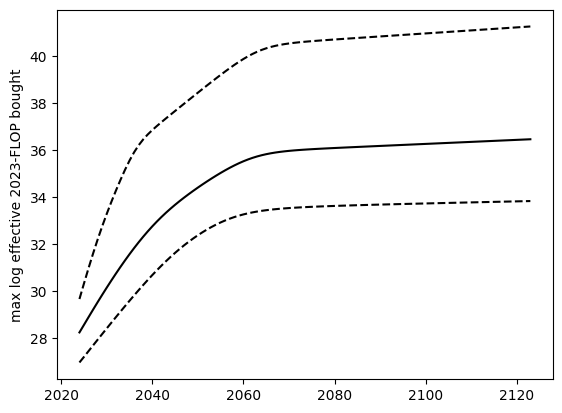

Year: 2024 - max log effective 2023-FLOP 28.2 (~17 octillion) 90% CI 27.0 (~908 septillion) - 29.7 (~453 octillion)
Year: 2025 - max log effective 2023-FLOP 28.6 (~36 octillion) 90% CI 27.2 (~2 octillion) - 30.3 (~2 nonillion)
Year: 2026 - max log effective 2023-FLOP 28.9 (~77 octillion) 90% CI 27.4 (~3 octillion) - 31.0 (~9 nonillion)
Year: 2027 - max log effective 2023-FLOP 29.2 (~161 octillion) 90% CI 27.7 (~5 octillion) - 31.6 (~39 nonillion)
Year: 2028 - max log effective 2023-FLOP 29.5 (~335 octillion) 90% CI 27.9 (~8 octillion) - 32.2 (~155 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.8 (~687 octillion) 90% CI 28.2 (~15 octillion) - 32.8 (~565 nonillion)
Year: 2030 - max log effective 2023-FLOP 30.1 (~1 nonillion) 90% CI 28.4 (~26 octillion) - 33.3 (~2 decillion)
Year: 2031 - max log effective 2023-FLOP 30.4 (~3 nonillion) 90% CI 28.6 (~44 octillion) - 33.8 (~6 decillion)
Year: 2032 - max log effective 2023-FLOP 30.7 (~5 nonillion) 90% CI 28.9 (~77 octillion) - 34.3 (~

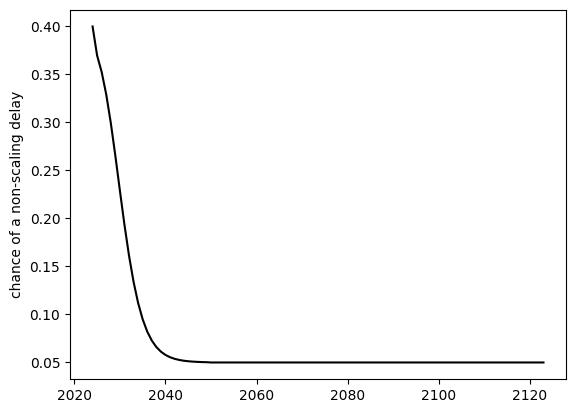

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2034

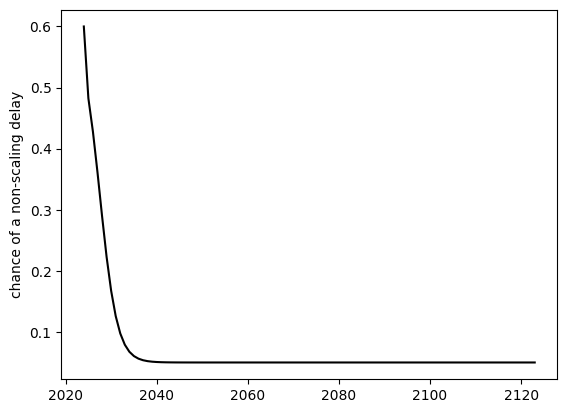

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 43%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 36%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2034 

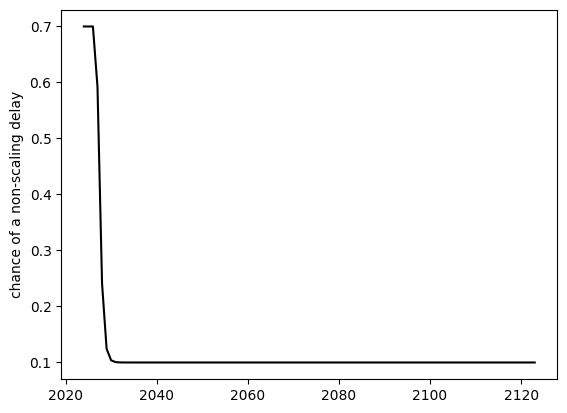

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034

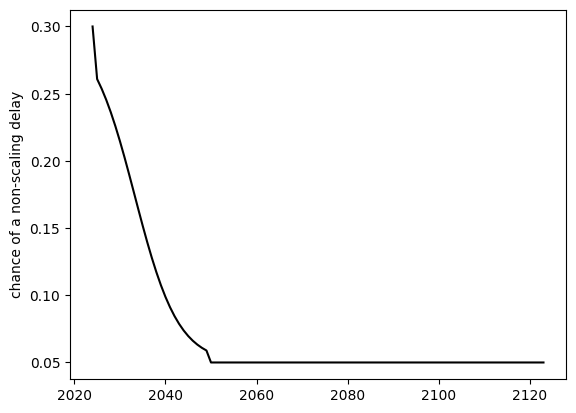

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2034

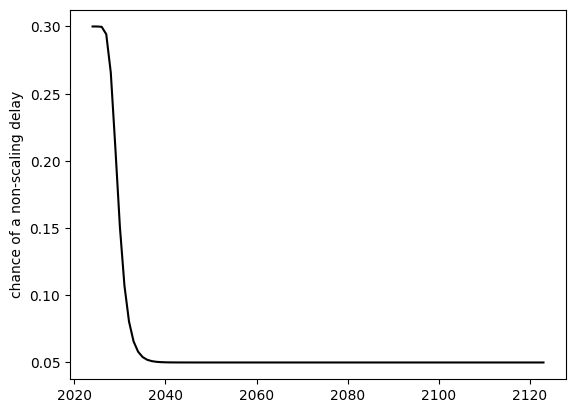

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2034 -

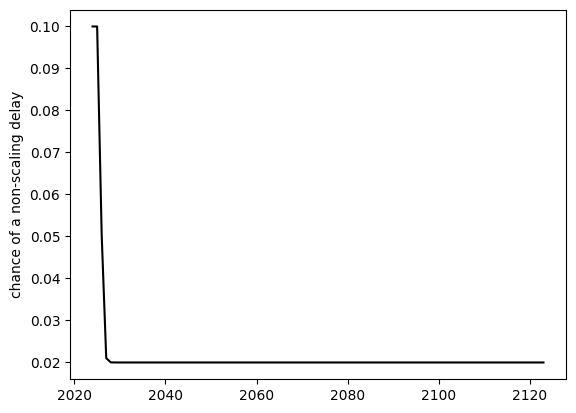

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chanc

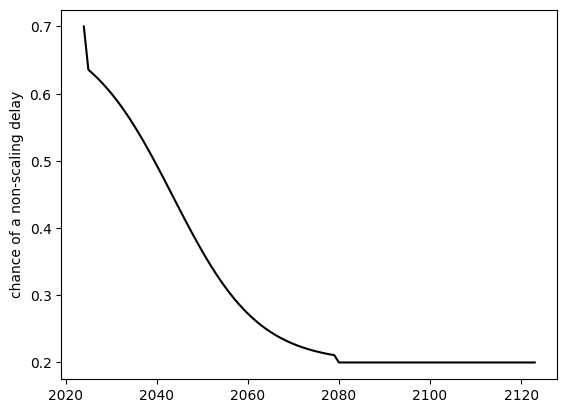

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 63%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 61%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2034

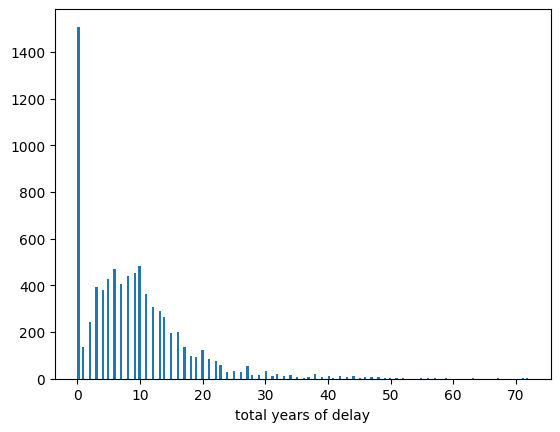

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~825 quintillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1 billion). This doubles every 4.1 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2024 - 27.3 max log FLOP available - TAI takes 32.6 log FLOP - log 2023$USD 14.4 to buy TAI vs. willingness to pay log $ 9.0 - 18.2 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.4 max log FLOP available - TAI takes 32.5 log FLOP - log 2023$USD 14.1 to buy TAI vs. willingness to pay log $ 9.1 - 18.4 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.6)
Year: 2026 - 27.6 max log FLOP available - TAI takes 32.3 l

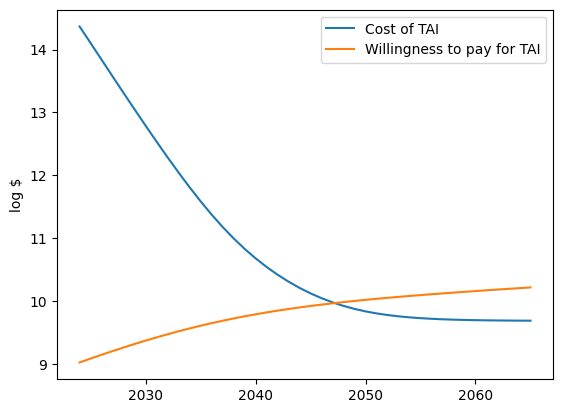

-
-
## SAMPLE RUN 5 ##
It takes 47.2 log FLOP (~158 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 6 log reductions possible.
FLOP start at a cost of 19.6 log FLOP (~39 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5 billion). This doubles every 9.3 year to a max of 0.45632% of GDP (initially ~114 billion 2023$USD). GDP grows at a rate of 1.041x per year.
---
Year: 2024 - 29.3 max log FLOP available - TAI takes 47.2 log FLOP - log 2023$USD 27.6 to buy TAI vs. willingness to pay log $ 9.7 - 19.6 log FLOP per $ (Total FLOP 29.3 vs. Effective 2023-logFLOP: 29.3)
Year: 2025 - 29.4 max log FLOP available - TAI takes 46.9 log FLOP - log 2023$USD 27.2 to buy TAI vs. willingness to pay log $ 9.7 - 19.7 log FLOP per $ (Total FLOP 29.4 vs. Effective 2023-logFLOP: 29.7)
Year: 2026 - 29.5 max log FLOP available - TAI tak

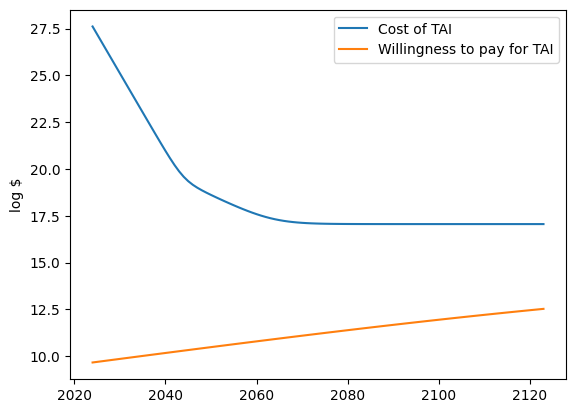

-
-
## SAMPLE RUN 6 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.8 log FLOP (~66 quintillion) per 2023$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~86 sextillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~593 million). This doubles every 1.8 year to a max of 0.039254% of GDP (initially ~10 billion 2023$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2024 - 28.6 max log FLOP available - TAI takes 26.0 log FLOP - log 2023$USD 6.2 to buy TAI vs. willingness to pay log $ 8.7 - 19.8 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_nonscaling_issue p=0.

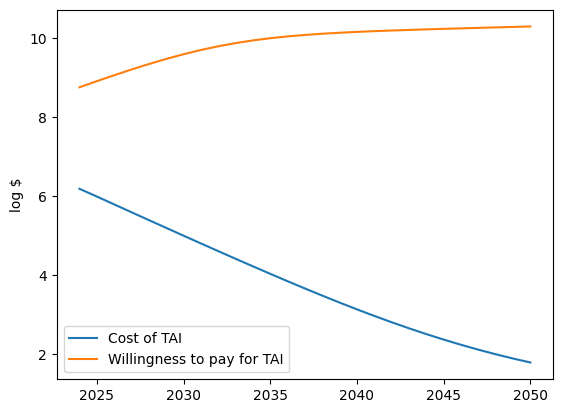

-
-
## SAMPLE RUN 7 ##
It takes 34.4 log FLOP (~25 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 28.0 max log FLOP available - TAI takes 34.4 log FLOP - log 2023$USD 15.6 to buy TAI vs. willingness to pay log $ 9.1 - 18.8 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.0)
Year: 2025 - 28.2 max log FLOP available - TAI takes 34.2 log FLOP - log 2023$USD 15.2 to buy TAI vs. willingness to pay log $ 9.3 - 19.0 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.4)
Year: 2026 - 28.5 max log FLOP available - TAI takes 34.0 log F

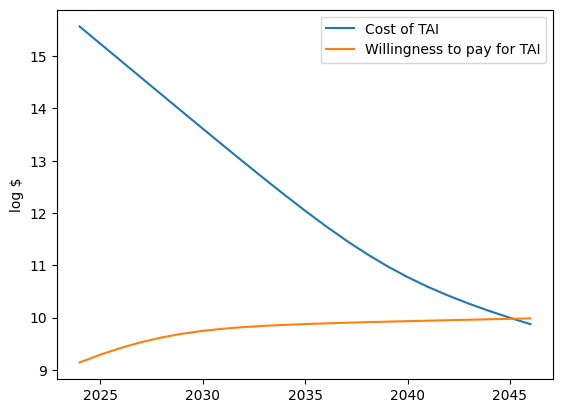

-
-
## SAMPLE RUN 8 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~15 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~104 sextillion) per 2023$USD.
We are initially willing to pay 10.1 log 2023$USD (~11 billion). This doubles every 4.7 year to a max of 0.102723% of GDP (initially ~26 billion 2023$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2024 - 29.1 max log FLOP available - TAI takes 38.3 log FLOP - log 2023$USD 19.1 to buy TAI vs. willingness to pay log $ 9.9 - 19.2 log FLOP per $ (Total FLOP 29.1 vs. Effective 2023-logFLOP: 29.1)
Year: 2025 - 29.3 max log FLOP available - TAI takes 38.0 log FLOP - log 2023$USD 18.7 to buy TAI vs. willingness to pay log $ 9.9 - 19.3 log FLOP per $ (Total FLOP 29.3 vs. Effective 2023-logFLOP: 29.6)
Year: 2026 - 29.4 max log FLOP available - TAI

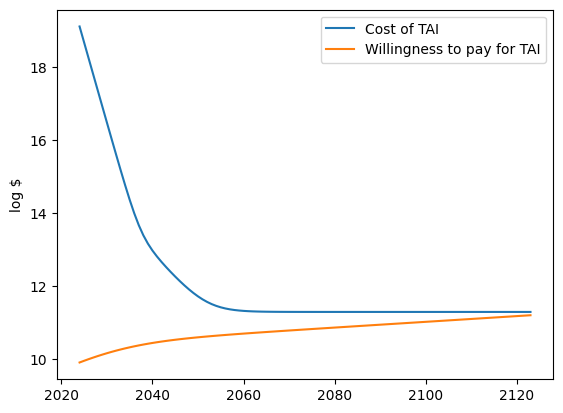

-
-
## SAMPLE RUN 9 ##
It takes 44.4 log FLOP (~251 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~35 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~856 sextillion) per 2023$USD.
We are initially willing to pay 8.8 log 2023$USD (~620 million). This doubles every 3.2 year to a max of 0.145728% of GDP (initially ~37 billion 2023$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2024 - 28.3 max log FLOP available - TAI takes 44.4 log FLOP - log 2023$USD 24.9 to buy TAI vs. willingness to pay log $ 8.8 - 19.5 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.3)
Year: 2025 - 28.5 max log FLOP available - TAI takes 44.1 log FLOP - log 2023$USD 24.4 to buy TAI vs. willingness to pay log $ 8.9 - 19.7 log FLOP per $ (Total FLOP 28.5 vs. Effective 2023-logFLOP: 28.8)
Year: 2026 - 28.7 max log FLOP available - TAI 

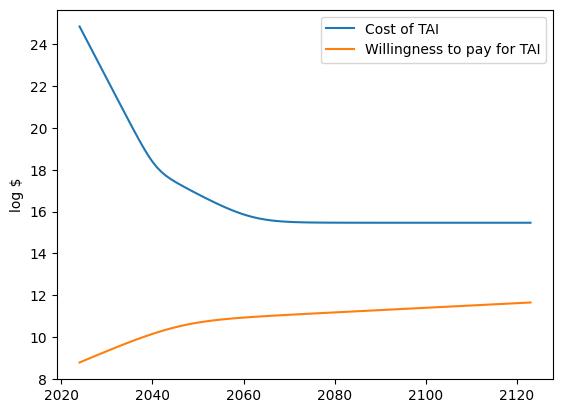

-
-
## SAMPLE RUN 10 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.8 log FLOP (~59 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 27.7 log FLOP (~5 octillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~4 billion). This doubles every 6.7 year to a max of 0.028577% of GDP (initially ~7 billion 2023$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2024 - 29.2 max log FLOP available - TAI takes 26.5 log FLOP - log 2023$USD 6.7 to buy TAI vs. willingness to pay log $ 9.4 - 19.8 log FLOP per $ (Total FLOP 29.2 vs. Effective 2023-logFLOP: 29.2)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay i

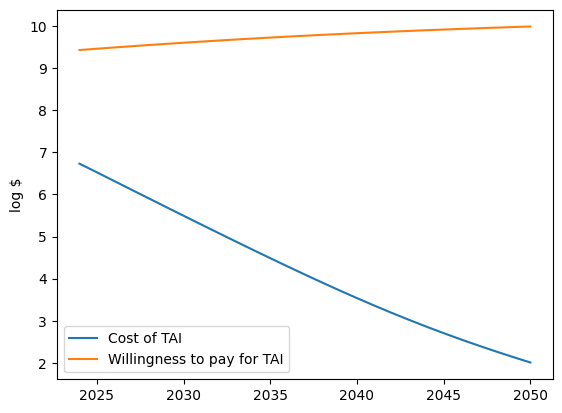

-
-
## SAMPLE RUN 11 ##
It takes 43.2 log FLOP (~16 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~15 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8 septillion) per 2023$USD.
We are initially willing to pay 9.5 log 2023$USD (~3 billion). This doubles every 3.6 year to a max of 0.592532% of GDP (initially ~147 billion 2023$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2024 - 28.6 max log FLOP available - TAI takes 43.2 log FLOP - log 2023$USD 24.0 to buy TAI vs. willingness to pay log $ 9.5 - 19.2 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.6)
Year: 2025 - 28.8 max log FLOP available - TAI takes 42.9 log FLOP - log 2023$USD 23.6 to buy TAI vs. willingness to pay log $ 9.6 - 19.3 log FLOP per $ (Total FLOP 28.8 vs. Effective 2023-logFLOP: 29.1)
Year: 2026 - 29.0 max log FLOP available - TAI tak

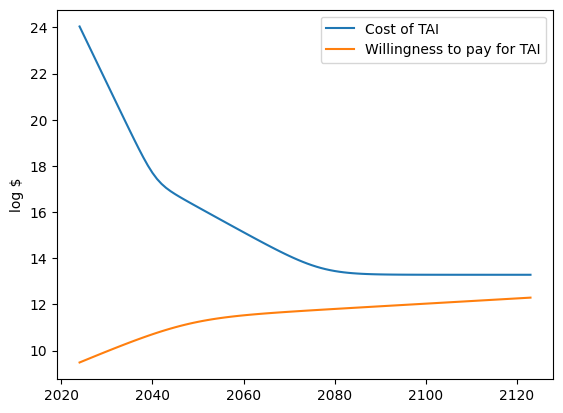

-
-
## SAMPLE RUN 12 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~14 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~585 sextillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~4 billion). This doubles every 1.8 year to a max of 0.039531% of GDP (initially ~10 billion 2023$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2024 - 28.6 max log FLOP available - TAI takes 25.6 log FLOP - log 2023$USD 6.4 to buy TAI vs. willingness to pay log $ 9.4 - 19.2 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- roboti

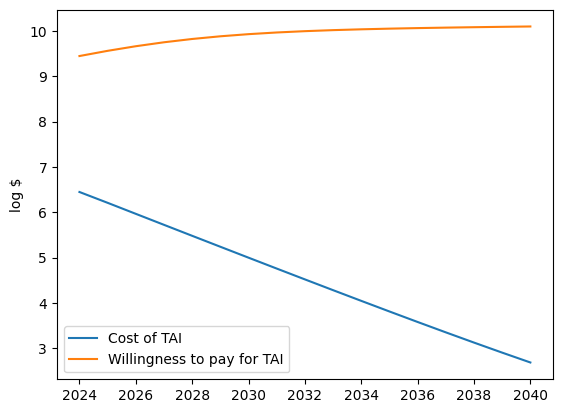

-
-
## SAMPLE RUN 13 ##
It takes 26.3 log FLOP (~200 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.7 log FLOP (~54 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~66 septillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~4 billion). This doubles every 7.9 year to a max of 0.052542% of GDP (initially ~13 billion 2023$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2024 - 29.2 max log FLOP available - TAI takes 26.3 log FLOP - log 2023$USD 6.6 to buy TAI vs. willingness to pay log $ 9.5 - 19.7 log FLOP per $ (Total FLOP 29.2 vs. Effective 2023-logFLOP: 29.2)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7

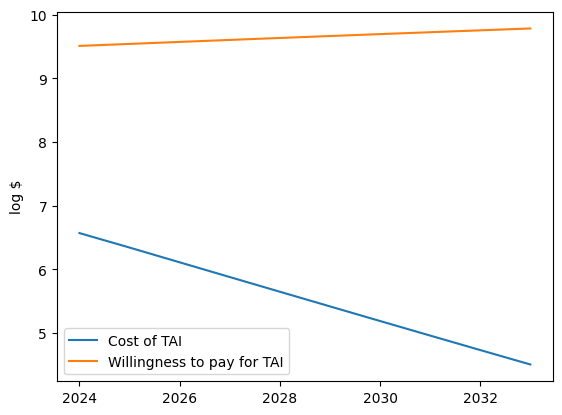

-
-
## SAMPLE RUN 14 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~4 billion). This doubles every 4.0 year to a max of 0.039814% of GDP (initially ~10 billion 2023$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2024 - 28.1 max log FLOP available - TAI takes 38.3 log FLOP - log 2023$USD 19.7 to buy TAI vs. willingness to pay log $ 9.4 - 18.6 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.1)
Year: 2025 - 28.2 max log FLOP available - TAI takes 38.0 log FLOP - log 2023$USD 19.3 to buy TAI vs. willingness to pay log $ 9.5 - 18.7 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.5)
Year: 2026 - 28.4 max log FLOP available - TAI tak

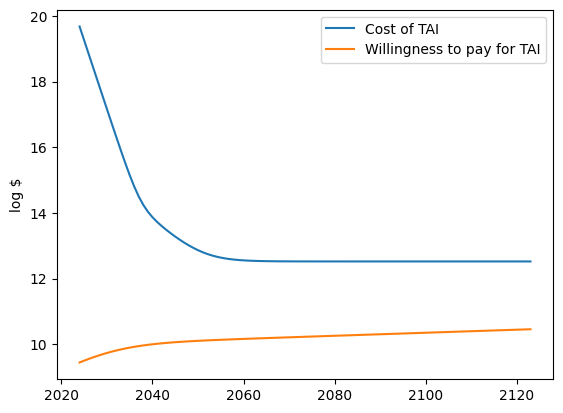

-
-
## SAMPLE RUN 15 ##
It takes 37.9 log FLOP (~79 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~32 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 1.5 year to a max of 0.816592% of GDP (initially ~203 billion 2023$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 37.9 log FLOP - log 2023$USD 19.4 to buy TAI vs. willingness to pay log $ 9.3 - 18.5 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.2 max log FLOP available - TAI takes 37.6 log FLOP - log 2023$USD 18.9 to buy TAI vs. willingness to pay log $ 9.5 - 18.7 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.5)
Year: 2026 - 28.5 max log FLOP available - TAI 

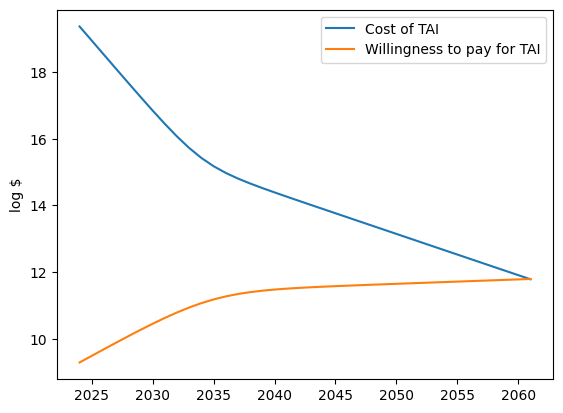

-
-
## SAMPLE RUN 16 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.6 log FLOP (~38 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~89 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2024 - 28.7 max log FLOP available - TAI takes 31.6 log FLOP - log 2023$USD 12.0 to buy TAI vs. willingness to pay log $ 9.1 - 19.6 log FLOP per $ (Total FLOP 28.7 vs. Effective 2023-logFLOP: 28.7)
Year: 2025 - 29.0 max log FLOP available - TAI takes 31.5 log FLOP - log 2023$USD 11.8 to buy TAI vs. willingness to pay log $ 9.3 - 19.7 log FLOP per $ (Total FLOP 29.0 vs. Effective 2023-logFLOP: 29.1)
Year: 2026 - 29.2 max log FLOP available - TAI takes 31.4 lo

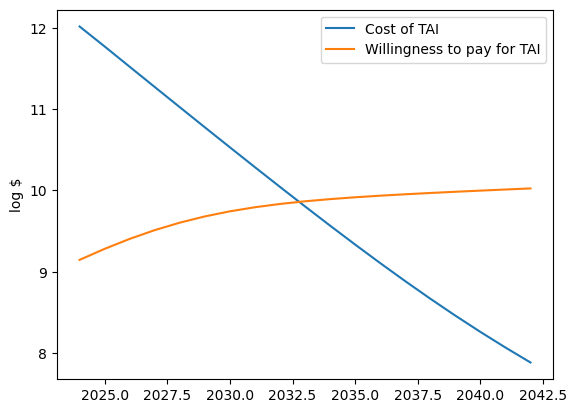

-
-
## SAMPLE RUN 17 ##
It takes 25.3 log FLOP (~20 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2023$USD.
We are initially willing to pay 8.6 log 2023$USD (~375 million). This doubles every 2.7 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2024 - 27.6 max log FLOP available - TAI takes 25.3 log FLOP - log 2023$USD 6.3 to buy TAI vs. willingness to pay log $ 8.5 - 19.0 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is

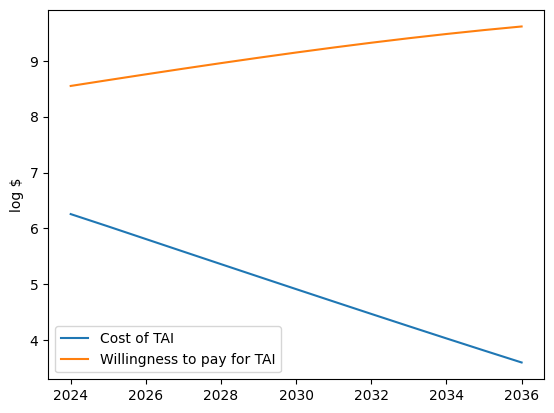

-
-
## SAMPLE RUN 18 ##
It takes 33.1 log FLOP (~1 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~721 sextillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1 billion). This doubles every 7.9 year to a max of 0.036859% of GDP (initially ~9 billion 2023$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 33.1 log FLOP - log 2023$USD 14.4 to buy TAI vs. willingness to pay log $ 9.1 - 18.7 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 33.0 log FLOP - log 2023$USD 14.1 to buy TAI vs. willingness to pay log $ 9.1 - 18.9 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.1)
Year: 2026 - 28.1 max log FLOP available - TAI takes 32.8 

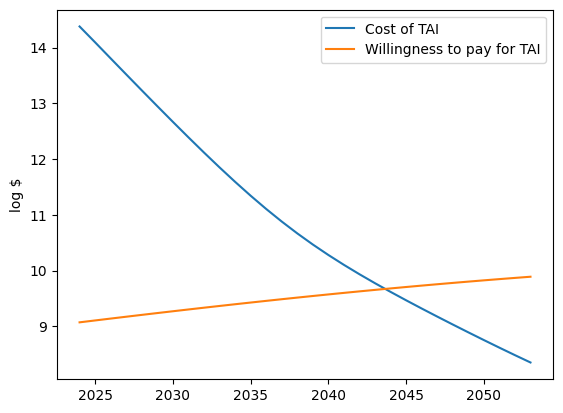

-
-
## SAMPLE RUN 19 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5 billion). This doubles every 1.9 year to a max of 1.257953% of GDP (initially ~317 billion 2023$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2024 - 28.6 max log FLOP available - TAI takes 26.1 log FLOP - log 2023$USD 7.2 to buy TAI vs. willingness to pay log $ 9.7 - 18.9 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling iss

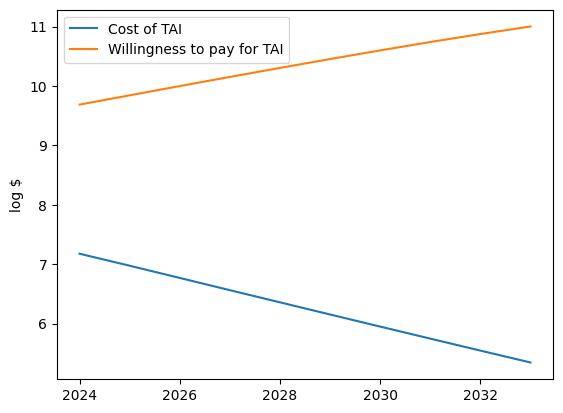

-
-
## SAMPLE RUN 20 ##
It takes 34.1 log FLOP (~13 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~4 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~479 sextillion) per 2023$USD.
We are initially willing to pay 9.4 log 2023$USD (~3 billion). This doubles every 2.6 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 34.1 log FLOP - log 2023$USD 15.6 to buy TAI vs. willingness to pay log $ 9.3 - 18.5 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 33.9 log FLOP - log 2023$USD 15.2 to buy TAI vs. willingness to pay log $ 9.4 - 18.7 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.2)
Year: 2026 - 28.2 max log FLOP available - TAI takes 33.7 lo

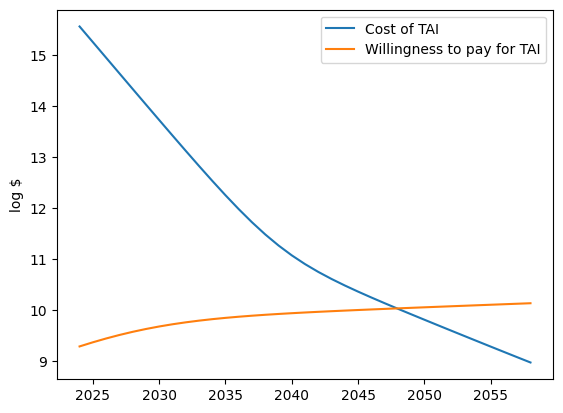

-
-
## SAMPLE RUN 21 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2023$USD.
We are initially willing to pay 9.4 log 2023$USD (~3 billion). This doubles every 6.5 year to a max of 0.078845% of GDP (initially ~20 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 27.5 max log FLOP available - TAI takes 26.2 log FLOP - log 2023$USD 8.1 to buy TAI vs. willingness to pay log $ 9.4 - 18.1 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay 

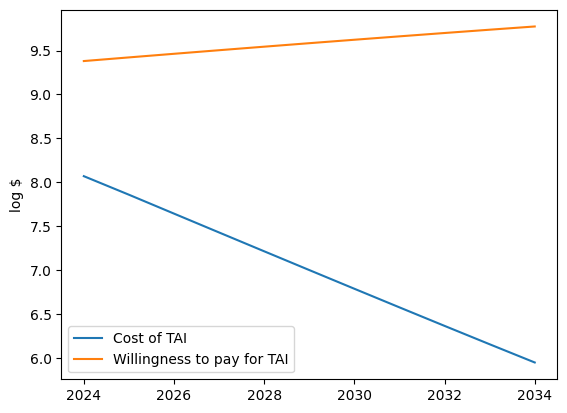

-
-
## SAMPLE RUN 22 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2023$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~577 sextillion) per 2023$USD.
We are initially willing to pay 9.4 log 2023$USD (~3 billion). This doubles every 4.4 year to a max of 0.032912% of GDP (initially ~8 billion 2023$USD). GDP grows at a rate of 1.006x per year.
---
Year: 2024 - 28.0 max log FLOP available - TAI takes 28.3 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 9.3 - 18.7 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.0)
Year: 2025 - 28.1 max log FLOP available - TAI takes 28.2 log FLOP - log 2023$USD 9.4 to buy TAI vs. willingness to pay log $ 9.4 - 18.8 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.2)
Year: 2026 - 28.3 max log FLOP available - TAI takes 28.1 l

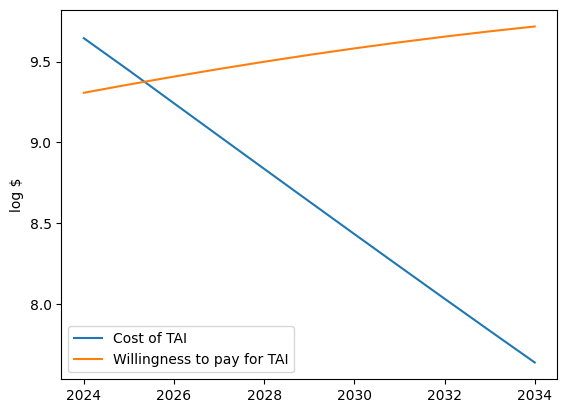

-
-
## SAMPLE RUN 23 ##
It takes 25.0 log FLOP (~10 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~57 sextillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1 billion). This doubles every 3.8 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 27.3 max log FLOP available - TAI takes 25.0 log FLOP - log 2023$USD 6.7 to buy TAI vs. willingness to pay log $ 9.0 - 18.3 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue di

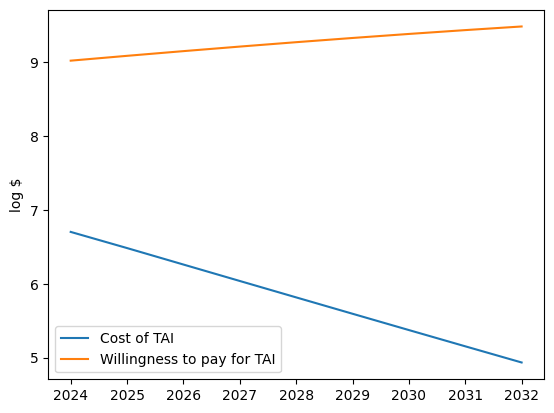

-
-
## SAMPLE RUN 24 ##
It takes 29.6 log FLOP (~398 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~95 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 3.3 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2024 - 28.1 max log FLOP available - TAI takes 29.6 log FLOP - log 2023$USD 10.7 to buy TAI vs. willingness to pay log $ 9.2 - 18.9 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.1)
Year: 2025 - 28.3 max log FLOP available - TAI takes 29.5 log FLOP - log 2023$USD 10.5 to buy TAI vs. willingness to pay log $ 9.3 - 19.0 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.4)
Year: 2026 - 28.5 max log FLOP available - TAI takes 29.4 lo

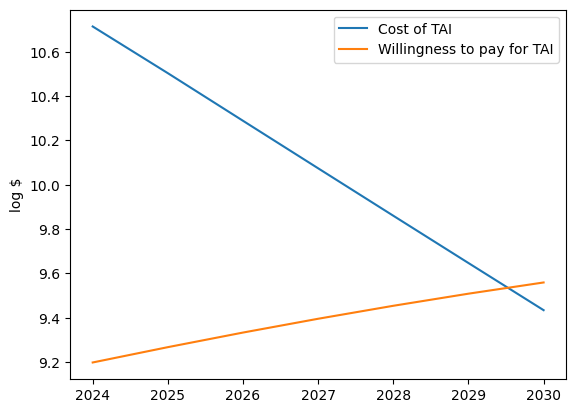

-
-
## SAMPLE RUN 25 ##
It takes 26.7 log FLOP (~501 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~11 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 27.1 log FLOP (~1 octillion) per 2023$USD.
We are initially willing to pay 9.4 log 2023$USD (~3 billion). This doubles every 1.9 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.007x per year.
---
Year: 2024 - 28.3 max log FLOP available - TAI takes 26.7 log FLOP - log 2023$USD 7.6 to buy TAI vs. willingness to pay log $ 9.3 - 19.1 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.3)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3

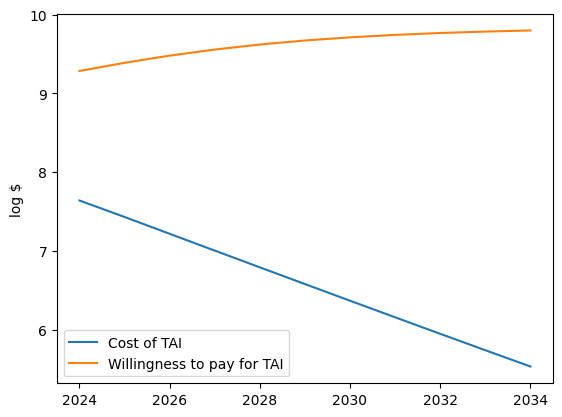

-
-
## SAMPLE RUN 26 ##
It takes 25.3 log FLOP (~20 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.6 log FLOP (~439 quadrillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~980 million). This doubles every 1.9 year to a max of 0.193424% of GDP (initially ~49 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 26.6 max log FLOP available - TAI takes 25.3 log FLOP - log 2023$USD 7.7 to buy TAI vs. willingness to pay log $ 9.0 - 17.6 log FLOP per $ (Total FLOP 26.6 vs. Effective 2023-logFLOP: 26.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this del

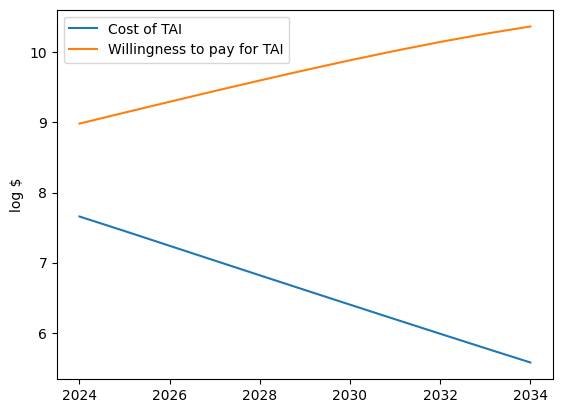

-
-
## SAMPLE RUN 27 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~11 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43 sextillion) per 2023$USD.
We are initially willing to pay 9.1 log 2023$USD (~1 billion). This doubles every 5.6 year to a max of 0.679334% of GDP (initially ~172 billion 2023$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2024 - 28.1 max log FLOP available - TAI takes 33.9 log FLOP - log 2023$USD 14.8 to buy TAI vs. willingness to pay log $ 9.1 - 19.1 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.1)
Year: 2025 - 28.3 max log FLOP available - TAI takes 33.8 log FLOP - log 2023$USD 14.6 to buy TAI vs. willingness to pay log $ 9.1 - 19.2 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.5)
Year: 2026 - 28.5 max log FLOP available - TAI takes 33.6

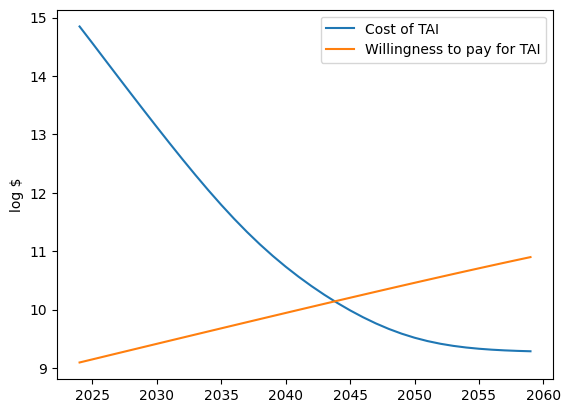

-
-
## SAMPLE RUN 28 ##
It takes 33.4 log FLOP (~3 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~882 million). This doubles every 1.9 year to a max of 0.029811% of GDP (initially ~7 billion 2023$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2024 - 27.4 max log FLOP available - TAI takes 33.4 log FLOP - log 2023$USD 14.9 to buy TAI vs. willingness to pay log $ 8.9 - 18.5 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.6 max log FLOP available - TAI takes 33.3 log FLOP - log 2023$USD 14.7 to buy TAI vs. willingness to pay log $ 9.0 - 18.6 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.8)
Year: 2026 - 27.9 max log FLOP available - TAI takes 33.1 

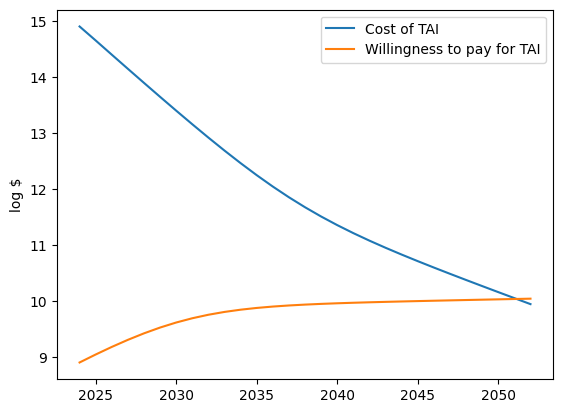

-
-
## SAMPLE RUN 29 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2023$USD.
We are initially willing to pay 9.5 log 2023$USD (~3 billion). This doubles every 6.5 year to a max of 0.045859% of GDP (initially ~12 billion 2023$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 27.5 log FLOP - log 2023$USD 9.1 to buy TAI vs. willingness to pay log $ 9.4 - 18.4 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p

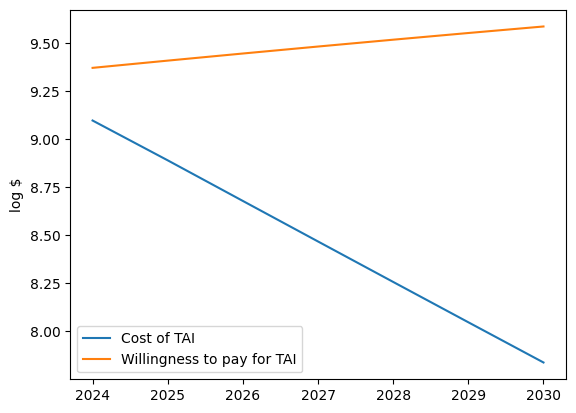

-
-
## SAMPLE RUN 30 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~15 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 2.2 year to a max of 0.040243% of GDP (initially ~10 billion 2023$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 28.5 log FLOP - log 2023$USD 9.3 to buy TAI vs. willingness to pay log $ 9.2 - 19.2 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
Year: 2025 - 28.6 max log FLOP available - TAI takes 28.4 log FLOP - log 2023$USD 9.1 to buy TAI vs. willingness to pay log $ 9.3 - 19.3 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.7)
-- algorithms p_nonscaling_issue p=0.3696 -> Nonscaling del

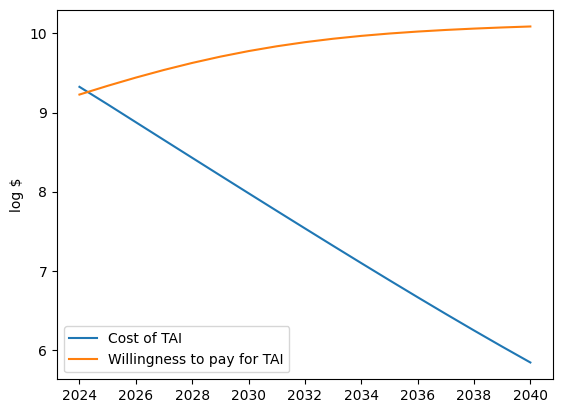

-
-
## SAMPLE RUN 31 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2023$USD.
We are initially willing to pay 9.9 log 2023$USD (~8 billion). This doubles every 3.6 year to a max of 0.182412% of GDP (initially ~46 billion 2023$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2024 - 28.8 max log FLOP available - TAI takes 27.4 log FLOP - log 2023$USD 8.4 to buy TAI vs. willingness to pay log $ 9.8 - 19.0 log FLOP per $ (Total FLOP 28.8 vs. Effective 2023-logFLOP: 28.8)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p

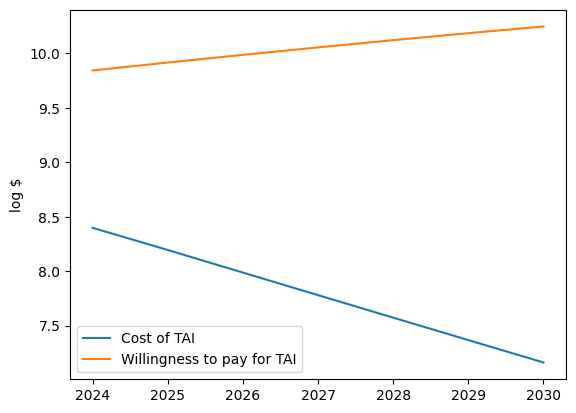

-
-
## SAMPLE RUN 32 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.9 log FLOP (~84 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5 billion). This doubles every 3.6 year to a max of 0.344976% of GDP (initially ~87 billion 2023$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2024 - 29.6 max log FLOP available - TAI takes 27.7 log FLOP - log 2023$USD 7.8 to buy TAI vs. willingness to pay log $ 9.7 - 19.9 log FLOP per $ (Total FLOP 29.6 vs. Effective 2023-logFLOP: 29.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics 

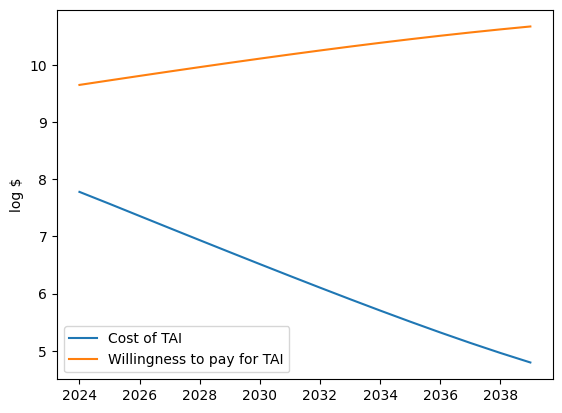

-
-
## SAMPLE RUN 33 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~105 septillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1 billion). This doubles every 8.4 year to a max of 0.085052% of GDP (initially ~21 billion 2023$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2024 - 28.2 max log FLOP available - TAI takes 29.2 log FLOP - log 2023$USD 10.2 to buy TAI vs. willingness to pay log $ 9.1 - 19.0 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.2)
Year: 2025 - 28.3 max log FLOP available - TAI takes 29.1 log FLOP - log 2023$USD 10.0 to buy TAI vs. willingness to pay log $ 9.2 - 19.1 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.4)
Year: 2026 - 28.5 max log FLOP available - TAI takes 2

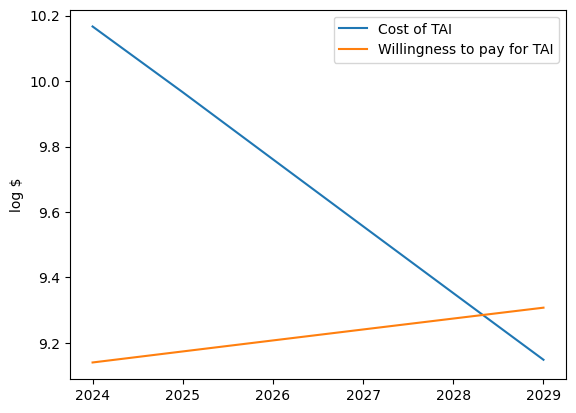

-
-
## SAMPLE RUN 34 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~28 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 1.8 year to a max of 0.615412% of GDP (initially ~154 billion 2023$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 28.9 log FLOP - log 2023$USD 9.8 to buy TAI vs. willingness to pay log $ 9.3 - 19.1 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
Year: 2025 - 28.7 max log FLOP available - TAI takes 28.8 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 9.5 - 19.2 log FLOP per $ (Total FLOP 28.7 vs. Effective 2023-logFLOP: 28.8)
Year: 2026 - 29.0 max log FLOP available - TAI takes 28.7

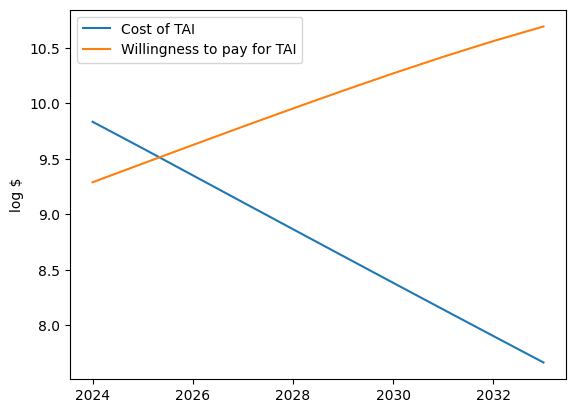

-
-
## SAMPLE RUN 35 ##
It takes 25.4 log FLOP (~25 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~30 quintillion) per 2023$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~130 sextillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~894 million). This doubles every 1.1 year to a max of 0.033862% of GDP (initially ~8 billion 2023$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 25.4 log FLOP - log 2023$USD 5.9 to buy TAI vs. willingness to pay log $ 8.9 - 19.5 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 3 years)
-- data p_nonscaling_issue p=0.

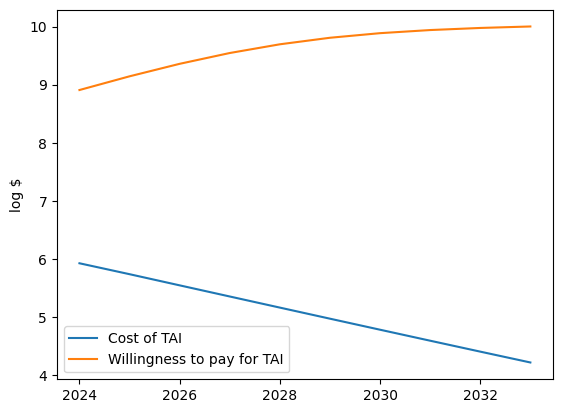

-
-
## SAMPLE RUN 36 ##
It takes 41.1 log FLOP (~126 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46 sextillion) per 2023$USD.
We are initially willing to pay 8.5 log 2023$USD (~315 million). This doubles every 4.0 year to a max of 0.305653% of GDP (initially ~76 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 27.2 max log FLOP available - TAI takes 41.1 log FLOP - log 2023$USD 22.4 to buy TAI vs. willingness to pay log $ 8.5 - 18.7 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.2)
Year: 2025 - 27.4 max log FLOP available - TAI takes 40.8 log FLOP - log 2023$USD 22.0 to buy TAI vs. willingness to pay log $ 8.6 - 18.8 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.7)
Year: 2026 - 27.6 max log FLOP available - TAI t

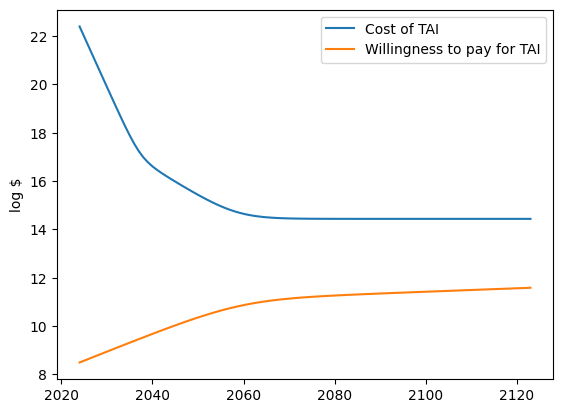

-
-
## SAMPLE RUN 37 ##
It takes 39.6 log FLOP (~4 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~873 million). This doubles every 1.5 year to a max of 0.0275% of GDP (initially ~7 billion 2023$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2024 - 27.7 max log FLOP available - TAI takes 39.6 log FLOP - log 2023$USD 20.8 to buy TAI vs. willingness to pay log $ 8.9 - 18.8 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 28.0 max log FLOP available - TAI takes 39.3 log FLOP - log 2023$USD 20.4 to buy TAI vs. willingness to pay log $ 9.1 - 18.9 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.2 max log FLOP available - TAI takes 3

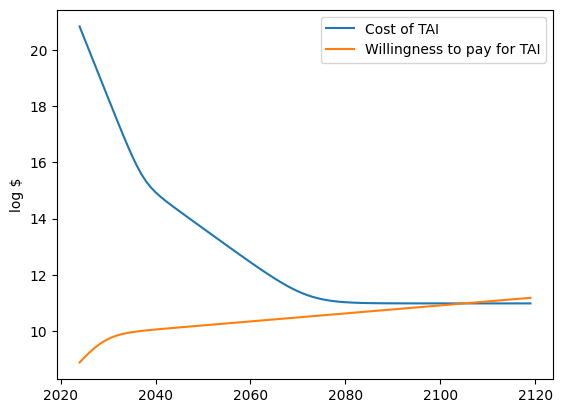

-
-
## SAMPLE RUN 38 ##
It takes 44.2 log FLOP (~158 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~9 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~225 sextillion) per 2023$USD.
We are initially willing to pay 9.8 log 2023$USD (~6 billion). This doubles every 1.5 year to a max of 1.543149% of GDP (initially ~388 billion 2023$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2024 - 28.7 max log FLOP available - TAI takes 44.2 log FLOP - log 2023$USD 25.2 to buy TAI vs. willingness to pay log $ 9.8 - 19.0 log FLOP per $ (Total FLOP 28.7 vs. Effective 2023-logFLOP: 28.7)
Year: 2025 - 29.1 max log FLOP available - TAI takes 43.9 log FLOP - log 2023$USD 24.8 to buy TAI vs. willingness to pay log $ 10.0 - 19.1 log FLOP per $ (Total FLOP 29.1 vs. Effective 2023-logFLOP: 29.4)
Year: 2026 - 29.4 max log FLOP available - TAI 

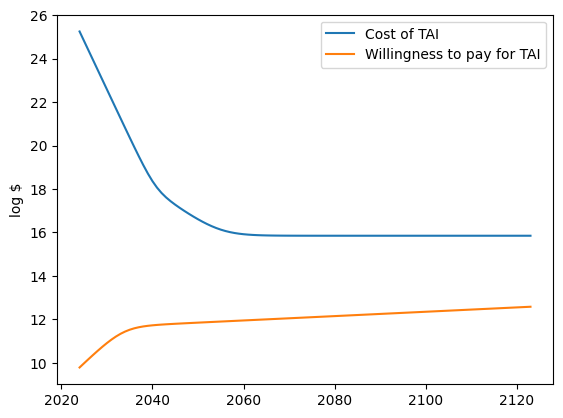

-
-
## SAMPLE RUN 39 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3 septillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 1.3 year to a max of 0.071014% of GDP (initially ~18 billion 2023$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2024 - 27.9 max log FLOP available - TAI takes 30.7 log FLOP - log 2023$USD 12.1 to buy TAI vs. willingness to pay log $ 9.2 - 18.6 log FLOP per $ (Total FLOP 27.9 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.2 max log FLOP available - TAI takes 30.6 log FLOP - log 2023$USD 11.8 to buy TAI vs. willingness to pay log $ 9.4 - 18.8 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.3)
Year: 2026 - 28.5 max log FLOP available - TAI takes 30.5 l

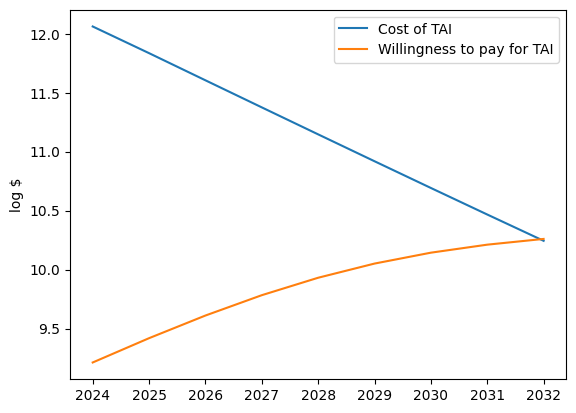

-
-
## SAMPLE RUN 40 ##
It takes 24.0 log FLOP (~1000 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~16 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~99 sextillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~2 billion). This doubles every 1.3 year to a max of 0.061181% of GDP (initially ~15 billion 2023$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 24.0 log FLOP - log 2023$USD 4.8 to buy TAI vs. willingness to pay log $ 9.2 - 19.2 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robot

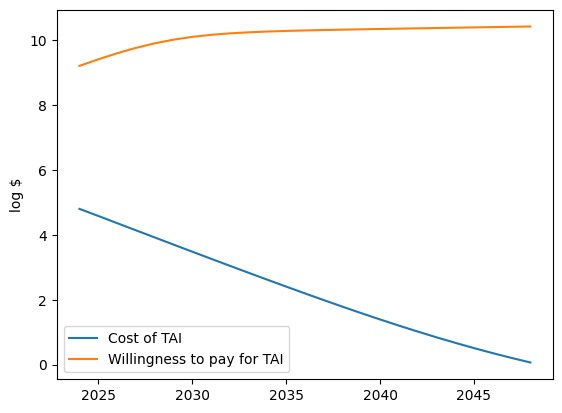

-
-
## SAMPLE RUN 41 ##
It takes 34.3 log FLOP (~20 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.3 log FLOP (~21 quintillion) per 2023$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3 septillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~4 billion). This doubles every 2.3 year to a max of 0.901139% of GDP (initially ~227 billion 2023$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2024 - 28.9 max log FLOP available - TAI takes 34.3 log FLOP - log 2023$USD 15.0 to buy TAI vs. willingness to pay log $ 9.6 - 19.3 log FLOP per $ (Total FLOP 28.9 vs. Effective 2023-logFLOP: 28.9)
Year: 2025 - 29.2 max log FLOP available - TAI takes 34.1 log FLOP - log 2023$USD 14.6 to buy TAI vs. willingness to pay log $ 9.7 - 19.5 log FLOP per $ (Total FLOP 29.2 vs. Effective 2023-logFLOP: 29.4)
Year: 2026 - 29.4 max log FLOP available - TAI takes 33.

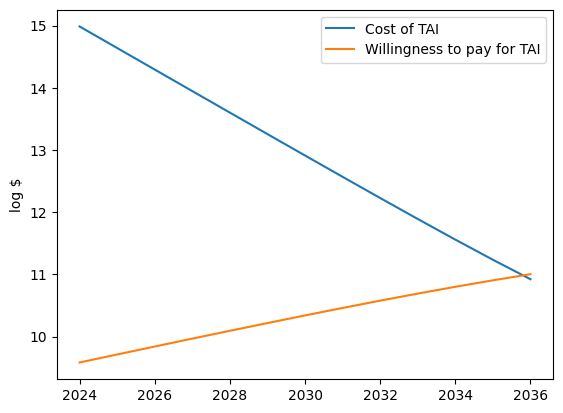

-
-
## SAMPLE RUN 42 ##
It takes 32.3 log FLOP (~200 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~33 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11 sextillion) per 2023$USD.
We are initially willing to pay 8.6 log 2023$USD (~374 million). This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.006x per year.
---
Year: 2024 - 28.1 max log FLOP available - TAI takes 32.3 log FLOP - log 2023$USD 12.8 to buy TAI vs. willingness to pay log $ 8.5 - 19.5 log FLOP per $ (Total FLOP 28.1 vs. Effective 2023-logFLOP: 28.1)
Year: 2025 - 28.4 max log FLOP available - TAI takes 32.2 log FLOP - log 2023$USD 12.5 to buy TAI vs. willingness to pay log $ 8.7 - 19.6 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.5)
Year: 2026 - 28.6 max log FLOP available - TAI takes 32.0

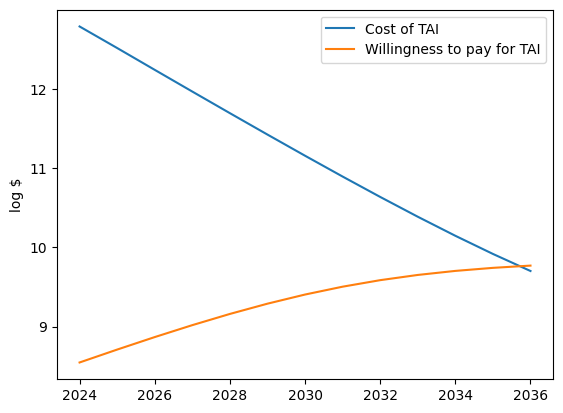

-
-
## SAMPLE RUN 43 ##
It takes 28.4 log FLOP (~25 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2023$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2023$USD.
We are initially willing to pay 10.0 log 2023$USD (~11 billion). This doubles every 2.6 year to a max of 0.320728% of GDP (initially ~80 billion 2023$USD). GDP grows at a rate of 1.013x per year.
---
Year: 2024 - 29.0 max log FLOP available - TAI takes 28.4 log FLOP - log 2023$USD 9.3 to buy TAI vs. willingness to pay log $ 10.0 - 19.1 log FLOP per $ (Total FLOP 29.0 vs. Effective 2023-logFLOP: 29.1)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this d

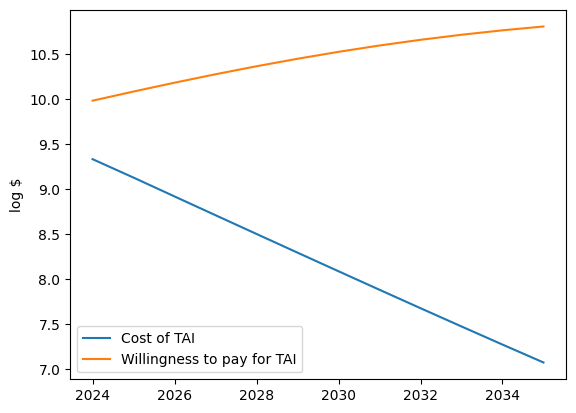

-
-
## SAMPLE RUN 44 ##
It takes 34.0 log FLOP (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~35 quintillion) per 2023$USD. Every 2.4 years they get 2x cheaper, to a maximum of 27.3 log FLOP (~2 octillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~1 billion). This doubles every 1.7 year to a max of 0.051695% of GDP (initially ~13 billion 2023$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2024 - 28.6 max log FLOP available - TAI takes 34.0 log FLOP - log 2023$USD 14.5 to buy TAI vs. willingness to pay log $ 9.1 - 19.5 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.6)
Year: 2025 - 28.9 max log FLOP available - TAI takes 33.9 log FLOP - log 2023$USD 14.2 to buy TAI vs. willingness to pay log $ 9.3 - 19.7 log FLOP per $ (Total FLOP 28.9 vs. Effective 2023-logFLOP: 29.1)
Year: 2026 - 29.2 max log FLOP available - TAI takes 33.7 

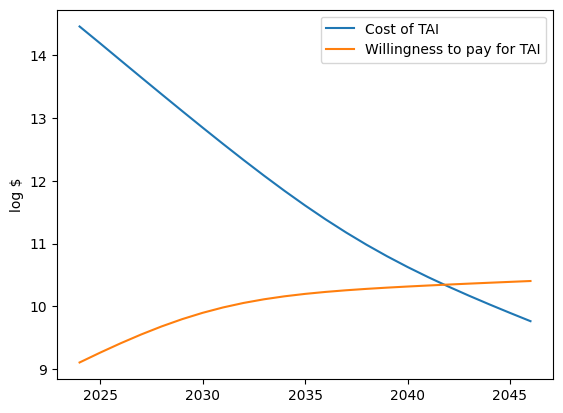

-
-
## SAMPLE RUN 45 ##
It takes 43.4 log FLOP (~25 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.8 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~15 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2023$USD.
We are initially willing to pay 9.3 log 2023$USD (~2 billion). This doubles every 2.9 year to a max of 0.051562% of GDP (initially ~13 billion 2023$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2024 - 28.4 max log FLOP available - TAI takes 43.4 log FLOP - log 2023$USD 24.2 to buy TAI vs. willingness to pay log $ 9.3 - 19.2 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.4)
Year: 2025 - 28.6 max log FLOP available - TAI takes 43.1 log FLOP - log 2023$USD 23.8 to buy TAI vs. willingness to pay log $ 9.3 - 19.3 log FLOP per $ (Total FLOP 28.6 vs. Effective 2023-logFLOP: 28.9)
Year: 2026 - 28.8 max log FLOP available - TAI ta

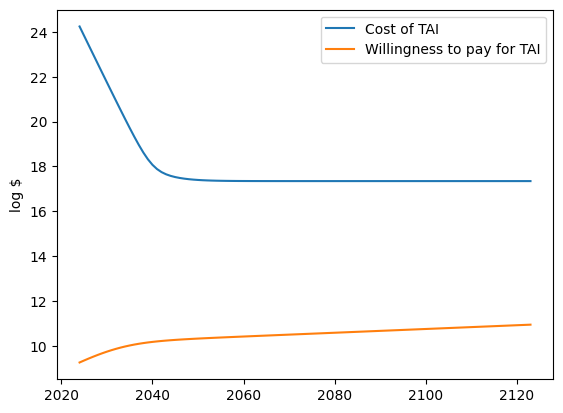

-
-
## SAMPLE RUN 46 ##
It takes 53.4 log FLOP (~251 quintillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 7 log reductions possible.
FLOP start at a cost of 19.3 log FLOP (~19 quintillion) per 2023$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1 septillion) per 2023$USD.
We are initially willing to pay 9.7 log 2023$USD (~5 billion). This doubles every 4.2 year to a max of 0.045757% of GDP (initially ~12 billion 2023$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2024 - 28.8 max log FLOP available - TAI takes 53.4 log FLOP - log 2023$USD 34.1 to buy TAI vs. willingness to pay log $ 9.6 - 19.3 log FLOP per $ (Total FLOP 28.8 vs. Effective 2023-logFLOP: 28.8)
Year: 2025 - 29.0 max log FLOP available - TAI takes 53.1 log FLOP - log 2023$USD 33.7 to buy TAI vs. willingness to pay log $ 9.6 - 19.4 log FLOP per $ (Total FLOP 29.0 vs. Effective 2023-logFLOP: 29.3)
Year: 2026 - 29.2 max log FLOP available - TAI

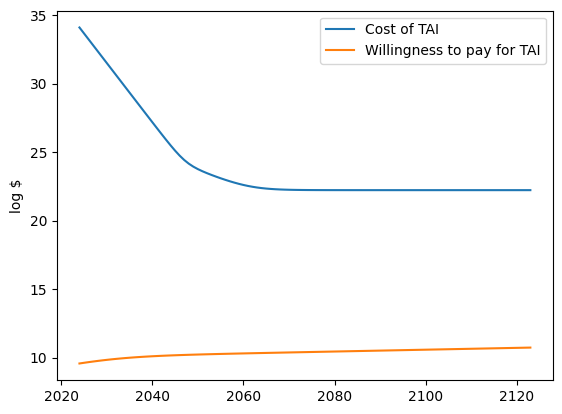

-
-
## SAMPLE RUN 47 ##
It takes 29.7 log FLOP (~501 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 26.5 log FLOP (~287 septillion) per 2023$USD.
We are initially willing to pay 9.4 log 2023$USD (~3 billion). This doubles every 2.5 year to a max of 0.03333% of GDP (initially ~8 billion 2023$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2024 - 27.8 max log FLOP available - TAI takes 29.7 log FLOP - log 2023$USD 11.2 to buy TAI vs. willingness to pay log $ 9.3 - 18.5 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 28.0 max log FLOP available - TAI takes 29.6 log FLOP - log 2023$USD 11.0 to buy TAI vs. willingness to pay log $ 9.4 - 18.6 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.1)
Year: 2026 - 28.2 max log FLOP available - TAI takes 29.5

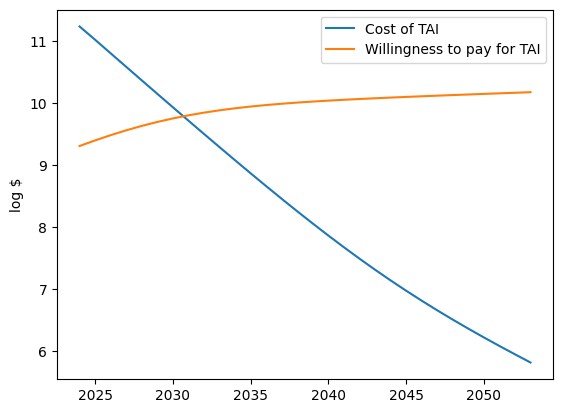

-
-
## SAMPLE RUN 48 ##
It takes 34.7 log FLOP (~50 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.4 log FLOP (~24 quintillion) per 2023$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~473 sextillion) per 2023$USD.
We are initially willing to pay 8.9 log 2023$USD (~861 million). This doubles every 3.2 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2024 - 28.3 max log FLOP available - TAI takes 34.7 log FLOP - log 2023$USD 15.3 to buy TAI vs. willingness to pay log $ 8.9 - 19.4 log FLOP per $ (Total FLOP 28.3 vs. Effective 2023-logFLOP: 28.3)
Year: 2025 - 28.4 max log FLOP available - TAI takes 34.5 log FLOP - log 2023$USD 15.0 to buy TAI vs. willingness to pay log $ 9.0 - 19.5 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.6)
Year: 2026 - 28.6 max log FLOP available - TAI takes 34.3

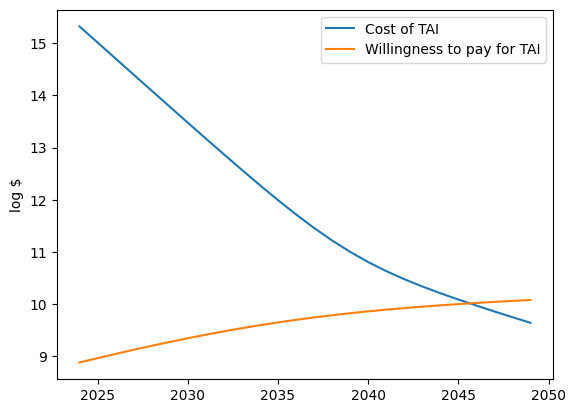

-
-
## SAMPLE RUN 49 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.7 log FLOP (~48 quintillion) per 2023$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~113 sextillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~2 billion). This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2024 - 28.8 max log FLOP available - TAI takes 28.3 log FLOP - log 2023$USD 8.6 to buy TAI vs. willingness to pay log $ 9.1 - 19.7 log FLOP per $ (Total FLOP 28.8 vs. Effective 2023-logFLOP: 28.8)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue

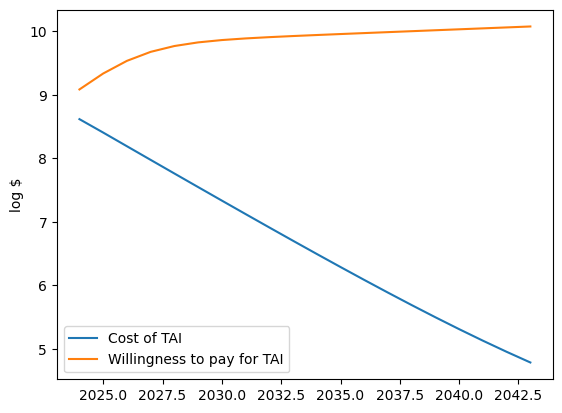

-
-
## SAMPLE RUN 50 ##
It takes 44.4 log FLOP (~251 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2023$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~967 quintillion) per 2023$USD.
We are initially willing to pay 9.0 log 2023$USD (~1 billion). This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6 billion 2023$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2024 - 27.4 max log FLOP available - TAI takes 44.4 log FLOP - log 2023$USD 26.0 to buy TAI vs. willingness to pay log $ 9.0 - 18.4 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.8 max log FLOP available - TAI takes 44.1 log FLOP - log 2023$USD 25.5 to buy TAI vs. willingness to pay log $ 9.2 - 18.6 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 28.1)
Year: 2026 - 28.2 max log FLOP available - TAI takes

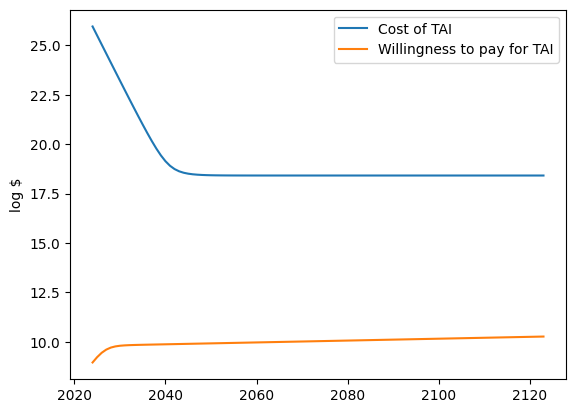

-
-
## SAMPLE RUN 51 ##
It takes 25.4 log FLOP (~25 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.6 log FLOP (~38 quintillion) per 2023$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1 septillion) per 2023$USD.
We are initially willing to pay 9.2 log 2023$USD (~2 billion). This doubles every 1.0 year to a max of 0.036439% of GDP (initially ~9 billion 2023$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2024 - 28.7 max log FLOP available - TAI takes 25.4 log FLOP - log 2023$USD 5.8 to buy TAI vs. willingness to pay log $ 9.1 - 19.6 log FLOP per $ (Total FLOP 28.7 vs. Effective 2023-logFLOP: 28.7)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay i

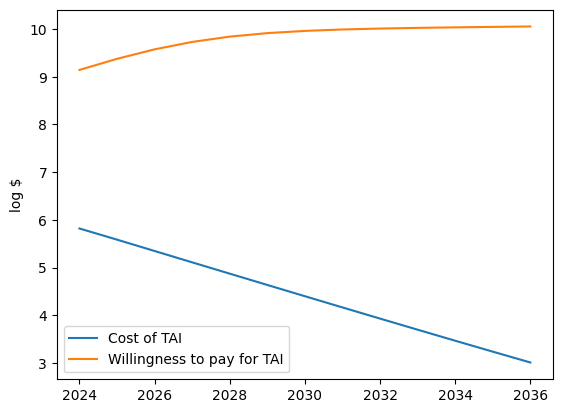

-
-
## SAMPLE RUN 52 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.5 log FLOP (~31 quintillion) per 2023$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51 sextillion) per 2023$USD.
We are initially willing to pay 9.6 log 2023$USD (~4 billion). This doubles every 2.3 year to a max of 0.069514% of GDP (initially ~17 billion 2023$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2024 - 29.0 max log FLOP available - TAI takes 32.5 log FLOP - log 2023$USD 13.0 to buy TAI vs. willingness to pay log $ 9.5 - 19.5 log FLOP per $ (Total FLOP 29.0 vs. Effective 2023-logFLOP: 29.0)
Year: 2025 - 29.2 max log FLOP available - TAI takes 32.4 log FLOP - log 2023$USD 12.7 to buy TAI vs. willingness to pay log $ 9.6 - 19.6 log FLOP per $ (Total FLOP 29.2 vs. Effective 2023-logFLOP: 29.4)
Year: 2026 - 29.4 max log FLOP available - TAI takes 32

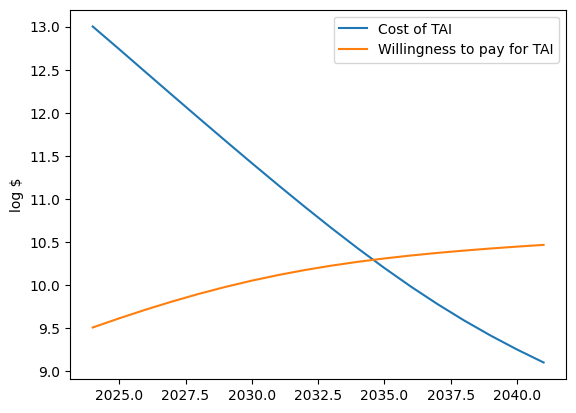

-
-
## SAMPLE RUN 53 ##
It takes 24.0 log FLOP (~1000 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~987 quadrillion) per 2023$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~522 sextillion) per 2023$USD.
We are initially willing to pay 9.5 log 2023$USD (~3 billion). This doubles every 3.5 year to a max of 0.17716% of GDP (initially ~45 billion 2023$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2024 - 27.4 max log FLOP available - TAI takes 24.0 log FLOP - log 2023$USD 6.0 to buy TAI vs. willingness to pay log $ 9.4 - 18.0 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this del

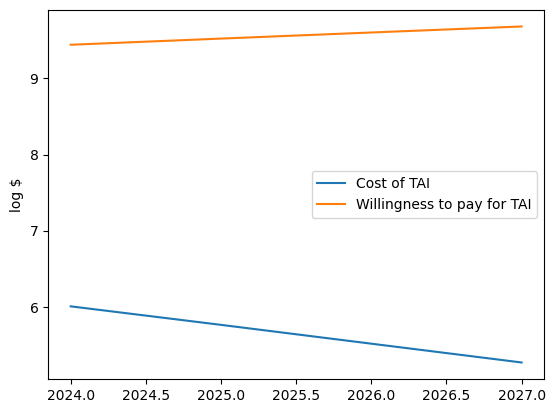

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-12-26 13:59:45.731926
